# Assignment 2:  Implicit Neural Representation

Name: Yi-Chung Chen

UID:  119218990

Link to Google Drive : **View-only Link to Notebook Here (make sure it works)**

Please submit a PDF containing all outputs to gradescope by **October 31, 11:59pm**

----------------------------

In this assignment, you will get some hands-on experience with implicit neural representation (INR). With INR, we parameterize some signal (in our case images) with a neural network (in this assignment, we will use a basic feed-forward network). While in practice this might be useful for outpainting, super-resolution, and compression, in this assignment we will mainly focus on the basics, with some proof-of-concept outpainting at the end. Your outputs might not look great, this is okay as long as they are at least as good as the examples.

## Dataset

As always, we start with the data. In this section, you will need to complete the following steps:

1. Choose an image. If you're working in colab, you will need to either mount your Google Drive, or else upload the file directly.
2. Write SingleImageDataset. This is how you'll convert your image into model inputs and targets. You will instantiate the dataset and a dataloader to check and make sure you did this part correctly.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Maryland/UMD/Robotics/Courses/2023 Fall/CMSC828I/Assignment 2'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


### Question 1: Selecting an image (5 points)

Free points! Just show your image here. One catch- make sure the image is less than 62500 pixels, total. We do not want you to waste time waiting for your model to train.

(150, 150, 3)


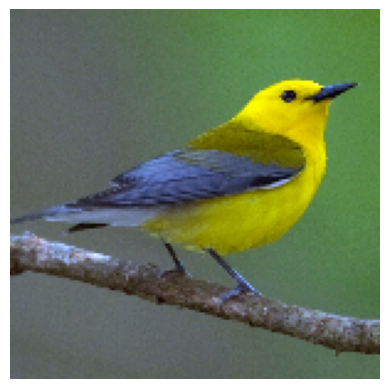

True

In [3]:
from torchvision.io import read_image  ## Note: feel free to use another loader
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

img_path = r'/content/drive/MyDrive/Maryland/UMD/Robotics/Courses/2023 Fall/CMSC828I/Assignment 2/'

image = cv2.imread(img_path + 'bird.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

height, width, _ = image.shape
re_size = 150


image = cv2.resize(image, (int(re_size), int(re_size)), interpolation= cv2.INTER_LINEAR)
print(image.shape)
plt.imshow(image)#.permute(1, 2, 0).numpy()
plt.axis('off')
plt.show()
plt.close()

# Save the resize image
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
os.chdir(img_path)
cv2.imwrite("image.png", image)

### Question 2: Writing the dataset (20 points)

For this part, you need to fill in the blanks for the dataset provided below. Alternatively, feel free to write it from scratch, the scaffolding was provided to help you, not to trap you in a box.

You will also need to write a loop to construct the image, using a dataloader for your SingleImageDataset. We provide more details in comments below.

We will be grading your code and your image outputs. In Gradescope, make sure both are fully visible.

In [4]:
from torchvision.io import read_image
from torch.utils.data import Dataset

class SingleImageDataset(Dataset):
    def __init__(self, img_path):
        self.image = read_image(img_path)
        self.num_channels, self.h, self.w = self.image.shape

    def __len__(self):
        ### TODO: 1 line of code for returning the number of pixels
        return self.h * self.w

    def __getitem__(self, idx):
        ### TODO: 2-3 lines of code for x, y, and pixel values
        x = (idx // self.w) % self.h
        y = idx % self.w
        intensity = np.asarray(self.image)[:, y, x]/255

        return {"x": x, "y": y, "intensity": intensity}

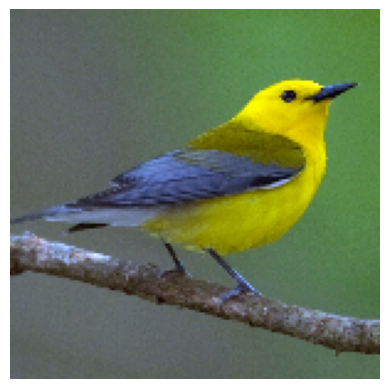

In [5]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataset = SingleImageDataset(img_path + 'image.png')

batch_size = 1
### TODO: 1 line of code for initializing a DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

### TODO: 6-10 lines of code for using your dataloader to retrieve, reassemble,
###       and display your image
reasmb_img = np.zeros((image.shape))

for batch in dataloader:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]
    reasmb_img[y.item(), x.item()] = np.asarray(intensity)[0]*255

plt.imshow(reasmb_img.astype(np.uint8))
plt.axis('off')
plt.show()

## Network


### Question 3: Defining the Network (15 points)

Define a feedforward neural network.
Remember that the last layer output dimension should be equal to the number of color channels.

A very basic network might have a linear layer, followed by a ReLU, followed by another linear layer.

In [6]:
import torch.nn as nn

class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        ### TODO: define and initialize some layers with weights
        self.layers = nn.Sequential(
            nn.Linear(2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3),
        )

    def forward(self, coord):
        out = self.layers(coord)
        return out


## Training

Now that you have a dataset and model, time to put it together!

Instantiate an optimizer and a criterion.
Loop over your dataset until the network converges.
Track your loss. We will be asking you to plot it later.

In [20]:
from numpy.ma.core import size
from tqdm import tqdm

device = ("cuda"
      if torch.cuda.is_available()
      else "mps"
      if torch.backends.mps.is_available()
      else "cpu")

print(f"Using {device} device")

net = FFN().to(device)

lr = 1e-4
b_size = 128

dataloader = DataLoader(dataset, batch_size=b_size, shuffle=False)

# since we are training the network for pixels,
# we will do a pixelwise MSE loss
criterion = torch.nn.MSELoss()

### TODO: 2 lines of code for optimizer, number of epochs
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
NUM_EPOCHS = 1000

loss_values = []
### TODO: set up mechanism for storing loss values
for epoch in tqdm(range(NUM_EPOCHS)):
  for batch in dataloader:
      x, y, actual = batch["x"], batch["y"], batch["intensity"]
      x = x / dataset.w # normalizing x between 0 and 1
      y = y / dataset.h # normalizing y between 0 and 1

      ### TODO: 3 lines of code to assemble coord from x and y, pass to net,
      ###       compute loss
      coord = torch.stack((x, y), dim=-1).to(device)
      pred = net(coord)
      loss = criterion(pred, actual.float().to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  ### TODO: track loss
  loss_values.append(loss.item())
  avg_loss = sum(loss_values) / len(loss_values)
  print(f"\nEpoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {avg_loss}\n")

torch.save(net.state_dict(), img_path+'save_model.pt')

Using cuda device


  0%|          | 1/1000 [00:00<09:57,  1.67it/s]


Epoch [1/1000], Loss: 0.004345856606960297



  0%|          | 2/1000 [00:01<10:03,  1.65it/s]


Epoch [2/1000], Loss: 0.004295249469578266



  0%|          | 3/1000 [00:01<10:00,  1.66it/s]


Epoch [3/1000], Loss: 0.0043294792994856834



  0%|          | 4/1000 [00:02<10:02,  1.65it/s]


Epoch [4/1000], Loss: 0.004396165604703128



  0%|          | 5/1000 [00:03<10:00,  1.66it/s]


Epoch [5/1000], Loss: 0.004398075491189956



  1%|          | 6/1000 [00:03<10:04,  1.64it/s]


Epoch [6/1000], Loss: 0.004432521993294358



  1%|          | 7/1000 [00:04<10:18,  1.60it/s]


Epoch [7/1000], Loss: 0.004429058637470007



  1%|          | 8/1000 [00:04<10:15,  1.61it/s]


Epoch [8/1000], Loss: 0.0044500603107735515



  1%|          | 9/1000 [00:05<10:09,  1.63it/s]


Epoch [9/1000], Loss: 0.004450998734682798



  1%|          | 10/1000 [00:06<10:03,  1.64it/s]


Epoch [10/1000], Loss: 0.004448277968913316



  1%|          | 11/1000 [00:06<10:07,  1.63it/s]


Epoch [11/1000], Loss: 0.00444639694284309



  1%|          | 12/1000 [00:07<10:01,  1.64it/s]


Epoch [12/1000], Loss: 0.0044429919992884



  1%|▏         | 13/1000 [00:07<10:04,  1.63it/s]


Epoch [13/1000], Loss: 0.00443159957201435



  1%|▏         | 14/1000 [00:08<10:56,  1.50it/s]


Epoch [14/1000], Loss: 0.004421170235478452



  2%|▏         | 15/1000 [00:09<11:50,  1.39it/s]


Epoch [15/1000], Loss: 0.004410635183254878



  2%|▏         | 16/1000 [00:10<12:29,  1.31it/s]


Epoch [16/1000], Loss: 0.004398785182274878



  2%|▏         | 17/1000 [00:11<13:02,  1.26it/s]


Epoch [17/1000], Loss: 0.004396718077580719



  2%|▏         | 18/1000 [00:12<13:13,  1.24it/s]


Epoch [18/1000], Loss: 0.004394034596367015



  2%|▏         | 19/1000 [00:12<13:20,  1.23it/s]


Epoch [19/1000], Loss: 0.004392151769838835



  2%|▏         | 20/1000 [00:13<13:28,  1.21it/s]


Epoch [20/1000], Loss: 0.004389878129586577



  2%|▏         | 21/1000 [00:14<12:28,  1.31it/s]


Epoch [21/1000], Loss: 0.0043943836353719234



  2%|▏         | 22/1000 [00:15<11:45,  1.39it/s]


Epoch [22/1000], Loss: 0.004400885050100359



  2%|▏         | 23/1000 [00:15<11:08,  1.46it/s]


Epoch [23/1000], Loss: 0.0044074798529238806



  2%|▏         | 24/1000 [00:16<10:46,  1.51it/s]


Epoch [24/1000], Loss: 0.004405817075166851



  2%|▎         | 25/1000 [00:16<10:41,  1.52it/s]


Epoch [25/1000], Loss: 0.00439833290874958



  3%|▎         | 26/1000 [00:17<10:25,  1.56it/s]


Epoch [26/1000], Loss: 0.00438767195177766



  3%|▎         | 27/1000 [00:18<10:17,  1.58it/s]


Epoch [27/1000], Loss: 0.004377526593291097



  3%|▎         | 28/1000 [00:18<10:04,  1.61it/s]


Epoch [28/1000], Loss: 0.004366487746925226



  3%|▎         | 29/1000 [00:19<10:04,  1.61it/s]


Epoch [29/1000], Loss: 0.0043595825514659795



  3%|▎         | 30/1000 [00:19<09:59,  1.62it/s]


Epoch [30/1000], Loss: 0.004353049630299211



  3%|▎         | 31/1000 [00:20<09:54,  1.63it/s]


Epoch [31/1000], Loss: 0.004348440726678218



  3%|▎         | 32/1000 [00:21<09:51,  1.64it/s]


Epoch [32/1000], Loss: 0.004345575915067457



  3%|▎         | 33/1000 [00:21<09:49,  1.64it/s]


Epoch [33/1000], Loss: 0.0043429557064717465



  3%|▎         | 34/1000 [00:22<09:54,  1.62it/s]


Epoch [34/1000], Loss: 0.004341946736745098



  4%|▎         | 35/1000 [00:23<09:52,  1.63it/s]


Epoch [35/1000], Loss: 0.004342426812010152



  4%|▎         | 36/1000 [00:23<09:47,  1.64it/s]


Epoch [36/1000], Loss: 0.004341541983497639



  4%|▎         | 37/1000 [00:24<10:42,  1.50it/s]


Epoch [37/1000], Loss: 0.004340724855963443



  4%|▍         | 38/1000 [00:25<11:35,  1.38it/s]


Epoch [38/1000], Loss: 0.004336258077895955



  4%|▍         | 39/1000 [00:26<12:19,  1.30it/s]


Epoch [39/1000], Loss: 0.004333653117124087



  4%|▍         | 40/1000 [00:27<12:41,  1.26it/s]


Epoch [40/1000], Loss: 0.004330778121948242



  4%|▍         | 41/1000 [00:27<12:59,  1.23it/s]


Epoch [41/1000], Loss: 0.00432808571154388



  4%|▍         | 42/1000 [00:28<13:11,  1.21it/s]


Epoch [42/1000], Loss: 0.004324213524038593



  4%|▍         | 43/1000 [00:29<13:16,  1.20it/s]


Epoch [43/1000], Loss: 0.004320203391618507



  4%|▍         | 44/1000 [00:30<12:12,  1.31it/s]


Epoch [44/1000], Loss: 0.004315234286795286



  4%|▍         | 45/1000 [00:30<11:22,  1.40it/s]


Epoch [45/1000], Loss: 0.004310660405705372



  5%|▍         | 46/1000 [00:31<10:51,  1.46it/s]


Epoch [46/1000], Loss: 0.0043059868292640085



  5%|▍         | 47/1000 [00:31<10:23,  1.53it/s]


Epoch [47/1000], Loss: 0.004300819571189424



  5%|▍         | 48/1000 [00:32<10:08,  1.56it/s]


Epoch [48/1000], Loss: 0.004295498268523564



  5%|▍         | 49/1000 [00:33<09:58,  1.59it/s]


Epoch [49/1000], Loss: 0.00429024446603595



  5%|▌         | 50/1000 [00:33<09:47,  1.62it/s]


Epoch [50/1000], Loss: 0.00428485912270844



  5%|▌         | 51/1000 [00:34<09:39,  1.64it/s]


Epoch [51/1000], Loss: 0.004279496549975639



  5%|▌         | 52/1000 [00:34<09:33,  1.65it/s]


Epoch [52/1000], Loss: 0.00427411909465893



  5%|▌         | 53/1000 [00:35<09:32,  1.65it/s]


Epoch [53/1000], Loss: 0.004269052841612753



  5%|▌         | 54/1000 [00:36<09:29,  1.66it/s]


Epoch [54/1000], Loss: 0.004263901988182355



  6%|▌         | 55/1000 [00:36<09:29,  1.66it/s]


Epoch [55/1000], Loss: 0.004258843663741242



  6%|▌         | 56/1000 [00:37<09:30,  1.66it/s]


Epoch [56/1000], Loss: 0.004253787088340947



  6%|▌         | 57/1000 [00:37<09:25,  1.67it/s]


Epoch [57/1000], Loss: 0.004248888689305699



  6%|▌         | 58/1000 [00:38<09:30,  1.65it/s]


Epoch [58/1000], Loss: 0.004244116761175723



  6%|▌         | 59/1000 [00:39<09:30,  1.65it/s]


Epoch [59/1000], Loss: 0.0042391743558316914



  6%|▌         | 60/1000 [00:39<09:54,  1.58it/s]


Epoch [60/1000], Loss: 0.004234519111923874



  6%|▌         | 61/1000 [00:40<11:01,  1.42it/s]


Epoch [61/1000], Loss: 0.004230032285644871



  6%|▌         | 62/1000 [00:41<11:42,  1.34it/s]


Epoch [62/1000], Loss: 0.004225342737270459



  6%|▋         | 63/1000 [00:42<12:04,  1.29it/s]


Epoch [63/1000], Loss: 0.004220890132562508



  6%|▋         | 64/1000 [00:43<12:22,  1.26it/s]


Epoch [64/1000], Loss: 0.004216509019897785



  6%|▋         | 65/1000 [00:44<12:38,  1.23it/s]


Epoch [65/1000], Loss: 0.004212069905434664



  7%|▋         | 66/1000 [00:44<12:43,  1.22it/s]


Epoch [66/1000], Loss: 0.0042078412264924155



  7%|▋         | 67/1000 [00:45<12:10,  1.28it/s]


Epoch [67/1000], Loss: 0.004203680325855515



  7%|▋         | 68/1000 [00:46<11:13,  1.38it/s]


Epoch [68/1000], Loss: 0.004200043608708417



  7%|▋         | 69/1000 [00:46<10:37,  1.46it/s]


Epoch [69/1000], Loss: 0.004196538778858772



  7%|▋         | 70/1000 [00:47<10:11,  1.52it/s]


Epoch [70/1000], Loss: 0.004193071302558695



  7%|▋         | 71/1000 [00:48<09:56,  1.56it/s]


Epoch [71/1000], Loss: 0.004189511741393469



  7%|▋         | 72/1000 [00:48<09:49,  1.57it/s]


Epoch [72/1000], Loss: 0.004186273985801058



  7%|▋         | 73/1000 [00:49<09:41,  1.60it/s]


Epoch [73/1000], Loss: 0.004182955983720005



  7%|▋         | 74/1000 [00:49<09:33,  1.61it/s]


Epoch [74/1000], Loss: 0.0041798898711095794



  8%|▊         | 75/1000 [00:50<09:23,  1.64it/s]


Epoch [75/1000], Loss: 0.004176765953501065



  8%|▊         | 76/1000 [00:51<09:17,  1.66it/s]


Epoch [76/1000], Loss: 0.004173939888316549



  8%|▊         | 77/1000 [00:51<09:15,  1.66it/s]


Epoch [77/1000], Loss: 0.004171039516033677



  8%|▊         | 78/1000 [00:52<09:14,  1.66it/s]


Epoch [78/1000], Loss: 0.004168308059422252



  8%|▊         | 79/1000 [00:52<09:14,  1.66it/s]


Epoch [79/1000], Loss: 0.004165310159184133



  8%|▊         | 80/1000 [00:53<09:11,  1.67it/s]


Epoch [80/1000], Loss: 0.004162362433271482



  8%|▊         | 81/1000 [00:54<09:12,  1.66it/s]


Epoch [81/1000], Loss: 0.004159373466937262



  8%|▊         | 82/1000 [00:54<09:09,  1.67it/s]


Epoch [82/1000], Loss: 0.004156549563404263



  8%|▊         | 83/1000 [00:55<09:09,  1.67it/s]


Epoch [83/1000], Loss: 0.0041537947492696434



  8%|▊         | 84/1000 [00:56<10:10,  1.50it/s]


Epoch [84/1000], Loss: 0.004150941541107993



  8%|▊         | 85/1000 [00:56<10:53,  1.40it/s]


Epoch [85/1000], Loss: 0.004148246961481431



  9%|▊         | 86/1000 [00:57<11:35,  1.31it/s]


Epoch [86/1000], Loss: 0.004145827046920394



  9%|▊         | 87/1000 [00:58<12:00,  1.27it/s]


Epoch [87/1000], Loss: 0.00414348394213908



  9%|▉         | 88/1000 [00:59<12:13,  1.24it/s]


Epoch [88/1000], Loss: 0.0041409751231020146



  9%|▉         | 89/1000 [01:00<12:23,  1.23it/s]


Epoch [89/1000], Loss: 0.00413858328077398



  9%|▉         | 90/1000 [01:01<12:21,  1.23it/s]


Epoch [90/1000], Loss: 0.0041361645898885194



  9%|▉         | 91/1000 [01:01<11:19,  1.34it/s]


Epoch [91/1000], Loss: 0.004133822816004465



  9%|▉         | 92/1000 [01:02<10:39,  1.42it/s]


Epoch [92/1000], Loss: 0.004131610490098272



  9%|▉         | 93/1000 [01:02<10:07,  1.49it/s]


Epoch [93/1000], Loss: 0.00412941277427699



  9%|▉         | 94/1000 [01:03<09:48,  1.54it/s]


Epoch [94/1000], Loss: 0.004127219705743358



 10%|▉         | 95/1000 [01:04<09:38,  1.57it/s]


Epoch [95/1000], Loss: 0.004124839393127906



 10%|▉         | 96/1000 [01:04<09:26,  1.59it/s]


Epoch [96/1000], Loss: 0.004122333465299259



 10%|▉         | 97/1000 [01:05<09:19,  1.61it/s]


Epoch [97/1000], Loss: 0.0041199331411842215



 10%|▉         | 98/1000 [01:05<09:14,  1.63it/s]


Epoch [98/1000], Loss: 0.004117166991725716



 10%|▉         | 99/1000 [01:06<09:10,  1.64it/s]


Epoch [99/1000], Loss: 0.004114635140550407



 10%|█         | 100/1000 [01:07<09:11,  1.63it/s]


Epoch [100/1000], Loss: 0.004111778575461358



 10%|█         | 101/1000 [01:07<09:03,  1.65it/s]


Epoch [101/1000], Loss: 0.00410856084787462



 10%|█         | 102/1000 [01:08<09:01,  1.66it/s]


Epoch [102/1000], Loss: 0.004105128961907444



 10%|█         | 103/1000 [01:08<09:00,  1.66it/s]


Epoch [103/1000], Loss: 0.004101754525604034



 10%|█         | 104/1000 [01:09<09:05,  1.64it/s]


Epoch [104/1000], Loss: 0.00409797078016429



 10%|█         | 105/1000 [01:10<09:03,  1.65it/s]


Epoch [105/1000], Loss: 0.004094109719707853



 11%|█         | 106/1000 [01:10<09:03,  1.64it/s]


Epoch [106/1000], Loss: 0.004090059006077079



 11%|█         | 107/1000 [01:11<09:44,  1.53it/s]


Epoch [107/1000], Loss: 0.004085908730940841



 11%|█         | 108/1000 [01:12<10:41,  1.39it/s]


Epoch [108/1000], Loss: 0.004081283344594003



 11%|█         | 109/1000 [01:13<11:11,  1.33it/s]


Epoch [109/1000], Loss: 0.004077079996398282



 11%|█         | 110/1000 [01:14<11:31,  1.29it/s]


Epoch [110/1000], Loss: 0.0040723198156973174



 11%|█         | 111/1000 [01:14<11:45,  1.26it/s]


Epoch [111/1000], Loss: 0.004067977861006249



 11%|█         | 112/1000 [01:15<11:55,  1.24it/s]


Epoch [112/1000], Loss: 0.0040630333533044904



 11%|█▏        | 113/1000 [01:16<12:02,  1.23it/s]


Epoch [113/1000], Loss: 0.004058727275464783



 11%|█▏        | 114/1000 [01:17<11:15,  1.31it/s]


Epoch [114/1000], Loss: 0.004053908071415336



 12%|█▏        | 115/1000 [01:17<10:31,  1.40it/s]


Epoch [115/1000], Loss: 0.004049310831191099



 12%|█▏        | 116/1000 [01:18<09:58,  1.48it/s]


Epoch [116/1000], Loss: 0.0040440478257770685



 12%|█▏        | 117/1000 [01:19<09:39,  1.52it/s]


Epoch [117/1000], Loss: 0.004039942657049649



 12%|█▏        | 118/1000 [01:19<09:26,  1.56it/s]


Epoch [118/1000], Loss: 0.004034918630337816



 12%|█▏        | 119/1000 [01:20<09:11,  1.60it/s]


Epoch [119/1000], Loss: 0.004031214808278224



 12%|█▏        | 120/1000 [01:20<09:04,  1.62it/s]


Epoch [120/1000], Loss: 0.004026220494415611



 12%|█▏        | 121/1000 [01:21<09:00,  1.63it/s]


Epoch [121/1000], Loss: 0.004022090882447756



 12%|█▏        | 122/1000 [01:22<08:55,  1.64it/s]


Epoch [122/1000], Loss: 0.004016340780835293



 12%|█▏        | 123/1000 [01:22<08:50,  1.65it/s]


Epoch [123/1000], Loss: 0.0040123733404145495



 12%|█▏        | 124/1000 [01:23<08:48,  1.66it/s]


Epoch [124/1000], Loss: 0.0040063832664952405



 12%|█▎        | 125/1000 [01:23<08:46,  1.66it/s]


Epoch [125/1000], Loss: 0.004001719113439321



 13%|█▎        | 126/1000 [01:24<08:53,  1.64it/s]


Epoch [126/1000], Loss: 0.003996302253596248



 13%|█▎        | 127/1000 [01:25<09:01,  1.61it/s]


Epoch [127/1000], Loss: 0.003991097208171144



 13%|█▎        | 128/1000 [01:25<09:01,  1.61it/s]


Epoch [128/1000], Loss: 0.003984485967521323



 13%|█▎        | 129/1000 [01:26<08:57,  1.62it/s]


Epoch [129/1000], Loss: 0.003978481705755342



 13%|█▎        | 130/1000 [01:27<09:17,  1.56it/s]


Epoch [130/1000], Loss: 0.00397156121997306



 13%|█▎        | 131/1000 [01:27<10:20,  1.40it/s]


Epoch [131/1000], Loss: 0.0039659867326210015



 13%|█▎        | 132/1000 [01:28<10:48,  1.34it/s]


Epoch [132/1000], Loss: 0.003959073849149387



 13%|█▎        | 133/1000 [01:29<11:18,  1.28it/s]


Epoch [133/1000], Loss: 0.003953374633425497



 13%|█▎        | 134/1000 [01:30<11:35,  1.25it/s]


Epoch [134/1000], Loss: 0.003946405578293463



 14%|█▎        | 135/1000 [01:31<11:50,  1.22it/s]


Epoch [135/1000], Loss: 0.003940228615990944



 14%|█▎        | 136/1000 [01:32<11:49,  1.22it/s]


Epoch [136/1000], Loss: 0.003933131889960564



 14%|█▎        | 137/1000 [01:32<11:20,  1.27it/s]


Epoch [137/1000], Loss: 0.0039259378788109025



 14%|█▍        | 138/1000 [01:33<10:30,  1.37it/s]


Epoch [138/1000], Loss: 0.003918626561652923



 14%|█▍        | 139/1000 [01:34<09:57,  1.44it/s]


Epoch [139/1000], Loss: 0.003911245656166252



 14%|█▍        | 140/1000 [01:34<09:31,  1.50it/s]


Epoch [140/1000], Loss: 0.0039039053338845928



 14%|█▍        | 141/1000 [01:35<09:18,  1.54it/s]


Epoch [141/1000], Loss: 0.0038962959615738255



 14%|█▍        | 142/1000 [01:35<09:03,  1.58it/s]


Epoch [142/1000], Loss: 0.0038892280697350352



 14%|█▍        | 143/1000 [01:36<08:54,  1.60it/s]


Epoch [143/1000], Loss: 0.00388175823035409



 14%|█▍        | 144/1000 [01:37<08:50,  1.61it/s]


Epoch [144/1000], Loss: 0.003873786716010525



 14%|█▍        | 145/1000 [01:37<08:44,  1.63it/s]


Epoch [145/1000], Loss: 0.003865760466854634



 15%|█▍        | 146/1000 [01:38<08:39,  1.64it/s]


Epoch [146/1000], Loss: 0.003857919000637756



 15%|█▍        | 147/1000 [01:38<08:37,  1.65it/s]


Epoch [147/1000], Loss: 0.0038499992790625615



 15%|█▍        | 148/1000 [01:39<08:38,  1.64it/s]


Epoch [148/1000], Loss: 0.0038419259362854064



 15%|█▍        | 149/1000 [01:40<08:39,  1.64it/s]


Epoch [149/1000], Loss: 0.003834202521536874



 15%|█▌        | 150/1000 [01:40<08:40,  1.63it/s]


Epoch [150/1000], Loss: 0.0038262101154153544



 15%|█▌        | 151/1000 [01:41<08:38,  1.64it/s]


Epoch [151/1000], Loss: 0.0038186850979159406



 15%|█▌        | 152/1000 [01:41<08:35,  1.64it/s]


Epoch [152/1000], Loss: 0.0038109465768732327



 15%|█▌        | 153/1000 [01:42<08:34,  1.65it/s]


Epoch [153/1000], Loss: 0.0038035309666560758



 15%|█▌        | 154/1000 [01:43<09:39,  1.46it/s]


Epoch [154/1000], Loss: 0.0037959646660374936



 16%|█▌        | 155/1000 [01:44<10:21,  1.36it/s]


Epoch [155/1000], Loss: 0.0037885500163200403



 16%|█▌        | 156/1000 [01:45<10:46,  1.31it/s]


Epoch [156/1000], Loss: 0.0037813047036671867



 16%|█▌        | 157/1000 [01:45<11:14,  1.25it/s]


Epoch [157/1000], Loss: 0.0037737588270620745



 16%|█▌        | 158/1000 [01:46<11:23,  1.23it/s]


Epoch [158/1000], Loss: 0.003766535771008628



 16%|█▌        | 159/1000 [01:47<11:29,  1.22it/s]


Epoch [159/1000], Loss: 0.003758974729176119



 16%|█▌        | 160/1000 [01:48<11:27,  1.22it/s]


Epoch [160/1000], Loss: 0.0037521110178204255



 16%|█▌        | 161/1000 [01:49<10:32,  1.33it/s]


Epoch [161/1000], Loss: 0.003744478388082074



 16%|█▌        | 162/1000 [01:49<09:50,  1.42it/s]


Epoch [162/1000], Loss: 0.003736849239004063



 16%|█▋        | 163/1000 [01:50<09:20,  1.49it/s]


Epoch [163/1000], Loss: 0.0037293093567542686



 16%|█▋        | 164/1000 [01:50<09:03,  1.54it/s]


Epoch [164/1000], Loss: 0.003721599444383528



 16%|█▋        | 165/1000 [01:51<08:50,  1.57it/s]


Epoch [165/1000], Loss: 0.0037147787695919927



 17%|█▋        | 166/1000 [01:52<08:38,  1.61it/s]


Epoch [166/1000], Loss: 0.0037068002913371624



 17%|█▋        | 167/1000 [01:52<08:31,  1.63it/s]


Epoch [167/1000], Loss: 0.0036989705439121603



 17%|█▋        | 168/1000 [01:53<08:27,  1.64it/s]


Epoch [168/1000], Loss: 0.0036912905606662945



 17%|█▋        | 169/1000 [01:53<08:24,  1.65it/s]


Epoch [169/1000], Loss: 0.0036844812325317654



 17%|█▋        | 170/1000 [01:54<08:18,  1.66it/s]


Epoch [170/1000], Loss: 0.00367707187337253



 17%|█▋        | 171/1000 [01:55<08:18,  1.66it/s]


Epoch [171/1000], Loss: 0.003669881935868608



 17%|█▋        | 172/1000 [01:55<08:17,  1.67it/s]


Epoch [172/1000], Loss: 0.0036623129935198745



 17%|█▋        | 173/1000 [01:56<08:15,  1.67it/s]


Epoch [173/1000], Loss: 0.0036547628548965288



 17%|█▋        | 174/1000 [01:56<08:16,  1.66it/s]


Epoch [174/1000], Loss: 0.003647212550611417



 18%|█▊        | 175/1000 [01:57<08:14,  1.67it/s]


Epoch [175/1000], Loss: 0.0036396993483815876



 18%|█▊        | 176/1000 [01:58<08:15,  1.66it/s]


Epoch [176/1000], Loss: 0.003632020341518166



 18%|█▊        | 177/1000 [01:58<08:59,  1.53it/s]


Epoch [177/1000], Loss: 0.0036249509920487128



 18%|█▊        | 178/1000 [01:59<09:50,  1.39it/s]


Epoch [178/1000], Loss: 0.0036176828199244115



 18%|█▊        | 179/1000 [02:00<10:25,  1.31it/s]


Epoch [179/1000], Loss: 0.0036104599653883685



 18%|█▊        | 180/1000 [02:01<10:49,  1.26it/s]


Epoch [180/1000], Loss: 0.003603099124868297



 18%|█▊        | 181/1000 [02:02<11:03,  1.23it/s]


Epoch [181/1000], Loss: 0.0035958680149311847



 18%|█▊        | 182/1000 [02:03<11:16,  1.21it/s]


Epoch [182/1000], Loss: 0.0035888193620389306



 18%|█▊        | 183/1000 [02:03<11:21,  1.20it/s]


Epoch [183/1000], Loss: 0.003582554371885019



 18%|█▊        | 184/1000 [02:04<10:33,  1.29it/s]


Epoch [184/1000], Loss: 0.0035756555292249213



 18%|█▊        | 185/1000 [02:05<09:54,  1.37it/s]


Epoch [185/1000], Loss: 0.003569789748085109



 19%|█▊        | 186/1000 [02:05<09:20,  1.45it/s]


Epoch [186/1000], Loss: 0.003563265845690283



 19%|█▊        | 187/1000 [02:06<08:59,  1.51it/s]


Epoch [187/1000], Loss: 0.0035569833698657584



 19%|█▉        | 188/1000 [02:07<08:49,  1.53it/s]


Epoch [188/1000], Loss: 0.003550787852641116



 19%|█▉        | 189/1000 [02:07<08:40,  1.56it/s]


Epoch [189/1000], Loss: 0.003543632622394297



 19%|█▉        | 190/1000 [02:08<08:31,  1.58it/s]


Epoch [190/1000], Loss: 0.0035378999995851986



 19%|█▉        | 191/1000 [02:08<08:30,  1.58it/s]


Epoch [191/1000], Loss: 0.0035309280178641308



 19%|█▉        | 192/1000 [02:09<08:23,  1.60it/s]


Epoch [192/1000], Loss: 0.003524761606968241



 19%|█▉        | 193/1000 [02:10<08:19,  1.62it/s]


Epoch [193/1000], Loss: 0.003518084218542193



 19%|█▉        | 194/1000 [02:10<08:15,  1.63it/s]


Epoch [194/1000], Loss: 0.003511913438788471



 20%|█▉        | 195/1000 [02:11<08:14,  1.63it/s]


Epoch [195/1000], Loss: 0.003505137891102678



 20%|█▉        | 196/1000 [02:11<08:10,  1.64it/s]


Epoch [196/1000], Loss: 0.003499149431579043



 20%|█▉        | 197/1000 [02:12<08:05,  1.66it/s]


Epoch [197/1000], Loss: 0.0034921406366422696



 20%|█▉        | 198/1000 [02:13<08:04,  1.66it/s]


Epoch [198/1000], Loss: 0.0034858881780463788



 20%|█▉        | 199/1000 [02:13<08:00,  1.67it/s]


Epoch [199/1000], Loss: 0.0034789834674634973



 20%|██        | 200/1000 [02:14<08:25,  1.58it/s]


Epoch [200/1000], Loss: 0.003472292284714058



 20%|██        | 201/1000 [02:15<09:21,  1.42it/s]


Epoch [201/1000], Loss: 0.003465353541391258



 20%|██        | 202/1000 [02:16<10:00,  1.33it/s]


Epoch [202/1000], Loss: 0.003459994125613334



 20%|██        | 203/1000 [02:16<10:21,  1.28it/s]


Epoch [203/1000], Loss: 0.0034540015779747604



 20%|██        | 204/1000 [02:17<10:35,  1.25it/s]


Epoch [204/1000], Loss: 0.0034472377509718725



 20%|██        | 205/1000 [02:18<10:50,  1.22it/s]


Epoch [205/1000], Loss: 0.003440252743752264



 21%|██        | 206/1000 [02:19<10:50,  1.22it/s]


Epoch [206/1000], Loss: 0.003435578374689427



 21%|██        | 207/1000 [02:20<10:17,  1.28it/s]


Epoch [207/1000], Loss: 0.0034291253240716054



 21%|██        | 208/1000 [02:20<09:34,  1.38it/s]


Epoch [208/1000], Loss: 0.0034226186846633656



 21%|██        | 209/1000 [02:21<09:08,  1.44it/s]


Epoch [209/1000], Loss: 0.003416122123376248



 21%|██        | 210/1000 [02:22<08:43,  1.51it/s]


Epoch [210/1000], Loss: 0.0034101678113940925



 21%|██        | 211/1000 [02:22<08:26,  1.56it/s]


Epoch [211/1000], Loss: 0.003403521077795687



 21%|██        | 212/1000 [02:23<08:20,  1.58it/s]


Epoch [212/1000], Loss: 0.0033972455432445233



 21%|██▏       | 213/1000 [02:23<08:09,  1.61it/s]


Epoch [213/1000], Loss: 0.0033906979602215015



 21%|██▏       | 214/1000 [02:24<08:02,  1.63it/s]


Epoch [214/1000], Loss: 0.0033844585288925286



 22%|██▏       | 215/1000 [02:24<07:56,  1.65it/s]


Epoch [215/1000], Loss: 0.0033782775773731773



 22%|██▏       | 216/1000 [02:25<07:54,  1.65it/s]


Epoch [216/1000], Loss: 0.003371952199678937



 22%|██▏       | 217/1000 [02:26<07:52,  1.66it/s]


Epoch [217/1000], Loss: 0.0033656124332447617



 22%|██▏       | 218/1000 [02:26<07:50,  1.66it/s]


Epoch [218/1000], Loss: 0.0033602395763518205



 22%|██▏       | 219/1000 [02:27<07:49,  1.66it/s]


Epoch [219/1000], Loss: 0.0033540067318231547



 22%|██▏       | 220/1000 [02:28<07:49,  1.66it/s]


Epoch [220/1000], Loss: 0.003347931450910189



 22%|██▏       | 221/1000 [02:28<07:54,  1.64it/s]


Epoch [221/1000], Loss: 0.0033423237405649947



 22%|██▏       | 222/1000 [02:29<07:57,  1.63it/s]


Epoch [222/1000], Loss: 0.0033365775682116013



 22%|██▏       | 223/1000 [02:29<07:57,  1.63it/s]


Epoch [223/1000], Loss: 0.0033307556280106174



 22%|██▏       | 224/1000 [02:30<08:52,  1.46it/s]


Epoch [224/1000], Loss: 0.003324410863050226



 22%|██▎       | 225/1000 [02:31<09:29,  1.36it/s]


Epoch [225/1000], Loss: 0.0033190911496058105



 23%|██▎       | 226/1000 [02:32<09:50,  1.31it/s]


Epoch [226/1000], Loss: 0.0033132495823217376



 23%|██▎       | 227/1000 [02:33<10:13,  1.26it/s]


Epoch [227/1000], Loss: 0.00330708020044663



 23%|██▎       | 228/1000 [02:34<10:22,  1.24it/s]


Epoch [228/1000], Loss: 0.0033012715187699846



 23%|██▎       | 229/1000 [02:34<10:34,  1.22it/s]


Epoch [229/1000], Loss: 0.0032952354603760173



 23%|██▎       | 230/1000 [02:35<10:26,  1.23it/s]


Epoch [230/1000], Loss: 0.00328964727839617



 23%|██▎       | 231/1000 [02:36<09:33,  1.34it/s]


Epoch [231/1000], Loss: 0.003283863690141508



 23%|██▎       | 232/1000 [02:36<08:59,  1.42it/s]


Epoch [232/1000], Loss: 0.00327805107547741



 23%|██▎       | 233/1000 [02:37<08:35,  1.49it/s]


Epoch [233/1000], Loss: 0.003272626250222837



 23%|██▎       | 234/1000 [02:38<08:19,  1.53it/s]


Epoch [234/1000], Loss: 0.003266250913660241



 24%|██▎       | 235/1000 [02:38<08:05,  1.58it/s]


Epoch [235/1000], Loss: 0.0032607807718375895



 24%|██▎       | 236/1000 [02:39<08:00,  1.59it/s]


Epoch [236/1000], Loss: 0.003254740736230229



 24%|██▎       | 237/1000 [02:39<07:53,  1.61it/s]


Epoch [237/1000], Loss: 0.003249874304614584



 24%|██▍       | 238/1000 [02:40<07:50,  1.62it/s]


Epoch [238/1000], Loss: 0.00324579090527611



 24%|██▍       | 239/1000 [02:41<07:49,  1.62it/s]


Epoch [239/1000], Loss: 0.003240775933126806



 24%|██▍       | 240/1000 [02:41<07:47,  1.62it/s]


Epoch [240/1000], Loss: 0.0032354728022861916



 24%|██▍       | 241/1000 [02:42<07:44,  1.63it/s]


Epoch [241/1000], Loss: 0.0032300210313454146



 24%|██▍       | 242/1000 [02:43<07:42,  1.64it/s]


Epoch [242/1000], Loss: 0.0032248927365934616



 24%|██▍       | 243/1000 [02:43<07:38,  1.65it/s]


Epoch [243/1000], Loss: 0.0032196453999566994



 24%|██▍       | 244/1000 [02:44<07:36,  1.65it/s]


Epoch [244/1000], Loss: 0.0032143959099022274



 24%|██▍       | 245/1000 [02:44<07:34,  1.66it/s]


Epoch [245/1000], Loss: 0.0032093795819436105



 25%|██▍       | 246/1000 [02:45<07:39,  1.64it/s]


Epoch [246/1000], Loss: 0.003204044396610461



 25%|██▍       | 247/1000 [02:46<08:24,  1.49it/s]


Epoch [247/1000], Loss: 0.0031989246478628533



 25%|██▍       | 248/1000 [02:47<09:09,  1.37it/s]


Epoch [248/1000], Loss: 0.003193470554129641



 25%|██▍       | 249/1000 [02:47<09:38,  1.30it/s]


Epoch [249/1000], Loss: 0.003188333350671343



 25%|██▌       | 250/1000 [02:48<10:03,  1.24it/s]


Epoch [250/1000], Loss: 0.0031828475990332665



 25%|██▌       | 251/1000 [02:49<10:07,  1.23it/s]


Epoch [251/1000], Loss: 0.003177682871455364



 25%|██▌       | 252/1000 [02:50<10:15,  1.22it/s]


Epoch [252/1000], Loss: 0.003172662484714584



 25%|██▌       | 253/1000 [02:51<10:25,  1.19it/s]


Epoch [253/1000], Loss: 0.0031677009243326697



 25%|██▌       | 254/1000 [02:52<09:34,  1.30it/s]


Epoch [254/1000], Loss: 0.0031629964804614154



 26%|██▌       | 255/1000 [02:52<08:55,  1.39it/s]


Epoch [255/1000], Loss: 0.003158407254765431



 26%|██▌       | 256/1000 [02:53<08:30,  1.46it/s]


Epoch [256/1000], Loss: 0.00315368415112971



 26%|██▌       | 257/1000 [02:53<08:10,  1.51it/s]


Epoch [257/1000], Loss: 0.0031490375913846296



 26%|██▌       | 258/1000 [02:54<08:00,  1.55it/s]


Epoch [258/1000], Loss: 0.0031439607995453964



 26%|██▌       | 259/1000 [02:55<07:51,  1.57it/s]


Epoch [259/1000], Loss: 0.003139082165740603



 26%|██▌       | 260/1000 [02:55<07:42,  1.60it/s]


Epoch [260/1000], Loss: 0.003134542199012895



 26%|██▌       | 261/1000 [02:56<07:38,  1.61it/s]


Epoch [261/1000], Loss: 0.0031298062566960396



 26%|██▌       | 262/1000 [02:56<07:33,  1.63it/s]


Epoch [262/1000], Loss: 0.00312541164804378



 26%|██▋       | 263/1000 [02:57<07:30,  1.64it/s]


Epoch [263/1000], Loss: 0.003120738370680452



 26%|██▋       | 264/1000 [02:58<07:27,  1.64it/s]


Epoch [264/1000], Loss: 0.0031159838937596896



 26%|██▋       | 265/1000 [02:58<07:25,  1.65it/s]


Epoch [265/1000], Loss: 0.0031110835235284746



 27%|██▋       | 266/1000 [02:59<07:29,  1.63it/s]


Epoch [266/1000], Loss: 0.0031061224526501632



 27%|██▋       | 267/1000 [02:59<07:25,  1.65it/s]


Epoch [267/1000], Loss: 0.003101354954530544



 27%|██▋       | 268/1000 [03:00<07:22,  1.65it/s]


Epoch [268/1000], Loss: 0.00309663890416164



 27%|██▋       | 269/1000 [03:01<07:20,  1.66it/s]


Epoch [269/1000], Loss: 0.003091869238750199



 27%|██▋       | 270/1000 [03:01<07:50,  1.55it/s]


Epoch [270/1000], Loss: 0.0030871703198903965



 27%|██▋       | 271/1000 [03:02<08:41,  1.40it/s]


Epoch [271/1000], Loss: 0.0030823712803361544



 27%|██▋       | 272/1000 [03:03<09:10,  1.32it/s]


Epoch [272/1000], Loss: 0.0030776762937688652



 27%|██▋       | 273/1000 [03:04<09:28,  1.28it/s]


Epoch [273/1000], Loss: 0.003072963705569533



 27%|██▋       | 274/1000 [03:05<09:45,  1.24it/s]


Epoch [274/1000], Loss: 0.003068204983613406



 28%|██▊       | 275/1000 [03:06<10:00,  1.21it/s]


Epoch [275/1000], Loss: 0.00306361740836027



 28%|██▊       | 276/1000 [03:06<10:01,  1.20it/s]


Epoch [276/1000], Loss: 0.003058865576969001



 28%|██▊       | 277/1000 [03:07<09:20,  1.29it/s]


Epoch [277/1000], Loss: 0.0030539329895003286



 28%|██▊       | 278/1000 [03:08<08:43,  1.38it/s]


Epoch [278/1000], Loss: 0.003049205085798669



 28%|██▊       | 279/1000 [03:08<08:17,  1.45it/s]


Epoch [279/1000], Loss: 0.0030442932190867574



 28%|██▊       | 280/1000 [03:09<07:58,  1.51it/s]


Epoch [280/1000], Loss: 0.0030393962191218246



 28%|██▊       | 281/1000 [03:10<07:43,  1.55it/s]


Epoch [281/1000], Loss: 0.0030346964432085696



 28%|██▊       | 282/1000 [03:10<07:34,  1.58it/s]


Epoch [282/1000], Loss: 0.003029992745310755



 28%|██▊       | 283/1000 [03:11<07:27,  1.60it/s]


Epoch [283/1000], Loss: 0.003025020825242222



 28%|██▊       | 284/1000 [03:11<07:28,  1.60it/s]


Epoch [284/1000], Loss: 0.0030202277588435044



 28%|██▊       | 285/1000 [03:12<07:25,  1.61it/s]


Epoch [285/1000], Loss: 0.0030155477052750557



 29%|██▊       | 286/1000 [03:13<07:20,  1.62it/s]


Epoch [286/1000], Loss: 0.003010754142578535



 29%|██▊       | 287/1000 [03:13<07:16,  1.63it/s]


Epoch [287/1000], Loss: 0.003005997751570122



 29%|██▉       | 288/1000 [03:14<07:14,  1.64it/s]


Epoch [288/1000], Loss: 0.003001236385090225



 29%|██▉       | 289/1000 [03:14<07:14,  1.63it/s]


Epoch [289/1000], Loss: 0.0029965454718955246



 29%|██▉       | 290/1000 [03:15<07:12,  1.64it/s]


Epoch [290/1000], Loss: 0.0029918112121683



 29%|██▉       | 291/1000 [03:16<07:11,  1.64it/s]


Epoch [291/1000], Loss: 0.0029870508585918914



 29%|██▉       | 292/1000 [03:16<07:09,  1.65it/s]


Epoch [292/1000], Loss: 0.0029822572936584585



 29%|██▉       | 293/1000 [03:17<07:31,  1.57it/s]


Epoch [293/1000], Loss: 0.002977513162253914



 29%|██▉       | 294/1000 [03:18<08:15,  1.43it/s]


Epoch [294/1000], Loss: 0.0029727675327175886



 30%|██▉       | 295/1000 [03:19<08:42,  1.35it/s]


Epoch [295/1000], Loss: 0.0029681389930389696



 30%|██▉       | 296/1000 [03:19<08:59,  1.30it/s]


Epoch [296/1000], Loss: 0.002963552617222524



 30%|██▉       | 297/1000 [03:20<09:12,  1.27it/s]


Epoch [297/1000], Loss: 0.0029589101019149226



 30%|██▉       | 298/1000 [03:21<09:25,  1.24it/s]


Epoch [298/1000], Loss: 0.002954703918970721



 30%|██▉       | 299/1000 [03:22<09:27,  1.23it/s]


Epoch [299/1000], Loss: 0.0029501967170247716



 30%|███       | 300/1000 [03:23<09:13,  1.27it/s]


Epoch [300/1000], Loss: 0.002945850534985463



 30%|███       | 301/1000 [03:23<08:30,  1.37it/s]


Epoch [301/1000], Loss: 0.002941392513341657



 30%|███       | 302/1000 [03:24<08:05,  1.44it/s]


Epoch [302/1000], Loss: 0.0029369162766429415



 30%|███       | 303/1000 [03:24<07:40,  1.51it/s]


Epoch [303/1000], Loss: 0.0029324385903855606



 30%|███       | 304/1000 [03:25<07:27,  1.56it/s]


Epoch [304/1000], Loss: 0.002927984488211989



 30%|███       | 305/1000 [03:26<07:18,  1.59it/s]


Epoch [305/1000], Loss: 0.002923786543218083



 31%|███       | 306/1000 [03:26<07:10,  1.61it/s]


Epoch [306/1000], Loss: 0.0029201827778974



 31%|███       | 307/1000 [03:27<07:07,  1.62it/s]


Epoch [307/1000], Loss: 0.002916287583396057



 31%|███       | 308/1000 [03:27<07:02,  1.64it/s]


Epoch [308/1000], Loss: 0.002912220218167459



 31%|███       | 309/1000 [03:28<06:59,  1.65it/s]


Epoch [309/1000], Loss: 0.002907976839302596



 31%|███       | 310/1000 [03:29<07:05,  1.62it/s]


Epoch [310/1000], Loss: 0.0029043053205485545



 31%|███       | 311/1000 [03:29<07:00,  1.64it/s]


Epoch [311/1000], Loss: 0.002900099061007261



 31%|███       | 312/1000 [03:30<07:02,  1.63it/s]


Epoch [312/1000], Loss: 0.0028968817447700226



 31%|███▏      | 313/1000 [03:31<06:58,  1.64it/s]


Epoch [313/1000], Loss: 0.002893103517594929



 31%|███▏      | 314/1000 [03:31<06:56,  1.65it/s]


Epoch [314/1000], Loss: 0.002890301401545976



 32%|███▏      | 315/1000 [03:32<06:54,  1.65it/s]


Epoch [315/1000], Loss: 0.00288665942951209



 32%|███▏      | 316/1000 [03:32<07:01,  1.62it/s]


Epoch [316/1000], Loss: 0.002883201366278661



 32%|███▏      | 317/1000 [03:33<07:49,  1.46it/s]


Epoch [317/1000], Loss: 0.0028796557036642727



 32%|███▏      | 318/1000 [03:34<08:18,  1.37it/s]


Epoch [318/1000], Loss: 0.002876212122650969



 32%|███▏      | 319/1000 [03:35<08:39,  1.31it/s]


Epoch [319/1000], Loss: 0.0028727797165127664



 32%|███▏      | 320/1000 [03:36<08:52,  1.28it/s]


Epoch [320/1000], Loss: 0.0028689757960819406



 32%|███▏      | 321/1000 [03:37<09:05,  1.24it/s]


Epoch [321/1000], Loss: 0.0028653608746043295



 32%|███▏      | 322/1000 [03:37<09:14,  1.22it/s]


Epoch [322/1000], Loss: 0.002861628818299668



 32%|███▏      | 323/1000 [03:38<09:06,  1.24it/s]


Epoch [323/1000], Loss: 0.0028577287808989084



 32%|███▏      | 324/1000 [03:39<08:27,  1.33it/s]


Epoch [324/1000], Loss: 0.0028538321353995277



 32%|███▎      | 325/1000 [03:39<07:57,  1.41it/s]


Epoch [325/1000], Loss: 0.0028498845307443005



 33%|███▎      | 326/1000 [03:40<07:39,  1.47it/s]


Epoch [326/1000], Loss: 0.0028459219550542487



 33%|███▎      | 327/1000 [03:41<07:22,  1.52it/s]


Epoch [327/1000], Loss: 0.0028419204448586165



 33%|███▎      | 328/1000 [03:41<07:13,  1.55it/s]


Epoch [328/1000], Loss: 0.002837903433118765



 33%|███▎      | 329/1000 [03:42<07:03,  1.58it/s]


Epoch [329/1000], Loss: 0.0028340205989670474



 33%|███▎      | 330/1000 [03:43<06:57,  1.60it/s]


Epoch [330/1000], Loss: 0.002830087787923262



 33%|███▎      | 331/1000 [03:43<06:55,  1.61it/s]


Epoch [331/1000], Loss: 0.0028263359359434587



 33%|███▎      | 332/1000 [03:44<06:52,  1.62it/s]


Epoch [332/1000], Loss: 0.0028225011739273927



 33%|███▎      | 333/1000 [03:44<06:51,  1.62it/s]


Epoch [333/1000], Loss: 0.00281876779067702



 33%|███▎      | 334/1000 [03:45<06:46,  1.64it/s]


Epoch [334/1000], Loss: 0.0028150420497216194



 34%|███▎      | 335/1000 [03:46<06:43,  1.65it/s]


Epoch [335/1000], Loss: 0.0028115012081784767



 34%|███▎      | 336/1000 [03:46<06:41,  1.65it/s]


Epoch [336/1000], Loss: 0.0028078289057399766



 34%|███▎      | 337/1000 [03:47<06:41,  1.65it/s]


Epoch [337/1000], Loss: 0.002804160738524149



 34%|███▍      | 338/1000 [03:47<06:40,  1.65it/s]


Epoch [338/1000], Loss: 0.0028003510859238327



 34%|███▍      | 339/1000 [03:48<06:38,  1.66it/s]


Epoch [339/1000], Loss: 0.0027966748910700587



 34%|███▍      | 340/1000 [03:49<07:28,  1.47it/s]


Epoch [340/1000], Loss: 0.0027927373987896476



 34%|███▍      | 341/1000 [03:50<08:01,  1.37it/s]


Epoch [341/1000], Loss: 0.00278908659702664



 34%|███▍      | 342/1000 [03:51<08:26,  1.30it/s]


Epoch [342/1000], Loss: 0.0027861864886747686



 34%|███▍      | 343/1000 [03:51<08:44,  1.25it/s]


Epoch [343/1000], Loss: 0.0027825084247466167



 34%|███▍      | 344/1000 [03:52<08:55,  1.22it/s]


Epoch [344/1000], Loss: 0.0027790161351900723



 34%|███▍      | 345/1000 [03:53<09:06,  1.20it/s]


Epoch [345/1000], Loss: 0.002775697011595079



 35%|███▍      | 346/1000 [03:54<09:06,  1.20it/s]


Epoch [346/1000], Loss: 0.002772354601271386



 35%|███▍      | 347/1000 [03:55<08:20,  1.31it/s]


Epoch [347/1000], Loss: 0.0027696601523124003



 35%|███▍      | 348/1000 [03:55<07:46,  1.40it/s]


Epoch [348/1000], Loss: 0.0027661920553902915



 35%|███▍      | 349/1000 [03:56<07:24,  1.46it/s]


Epoch [349/1000], Loss: 0.0027632683717023934



 35%|███▌      | 350/1000 [03:56<07:08,  1.52it/s]


Epoch [350/1000], Loss: 0.0027598089442056203



 35%|███▌      | 351/1000 [03:57<06:58,  1.55it/s]


Epoch [351/1000], Loss: 0.002756259765308828



 35%|███▌      | 352/1000 [03:58<06:51,  1.58it/s]


Epoch [352/1000], Loss: 0.002752611381517702



 35%|███▌      | 353/1000 [03:58<06:43,  1.60it/s]


Epoch [353/1000], Loss: 0.002748847110315672



 35%|███▌      | 354/1000 [03:59<06:42,  1.60it/s]


Epoch [354/1000], Loss: 0.0027452038599725414



 36%|███▌      | 355/1000 [03:59<06:43,  1.60it/s]


Epoch [355/1000], Loss: 0.0027416274023675164



 36%|███▌      | 356/1000 [04:00<06:40,  1.61it/s]


Epoch [356/1000], Loss: 0.0027381302523976085



 36%|███▌      | 357/1000 [04:01<06:39,  1.61it/s]


Epoch [357/1000], Loss: 0.0027344533834470753



 36%|███▌      | 358/1000 [04:01<06:31,  1.64it/s]


Epoch [358/1000], Loss: 0.002731197511038467



 36%|███▌      | 359/1000 [04:02<06:32,  1.63it/s]


Epoch [359/1000], Loss: 0.002728310668864352



 36%|███▌      | 360/1000 [04:02<06:32,  1.63it/s]


Epoch [360/1000], Loss: 0.0027247210728496107



 36%|███▌      | 361/1000 [04:03<06:34,  1.62it/s]


Epoch [361/1000], Loss: 0.0027219266140539396



 36%|███▌      | 362/1000 [04:04<06:33,  1.62it/s]


Epoch [362/1000], Loss: 0.002719087823672292



 36%|███▋      | 363/1000 [04:05<07:04,  1.50it/s]


Epoch [363/1000], Loss: 0.002716330851789964



 36%|███▋      | 364/1000 [04:05<07:40,  1.38it/s]


Epoch [364/1000], Loss: 0.0027132930072884145



 36%|███▋      | 365/1000 [04:06<08:06,  1.31it/s]


Epoch [365/1000], Loss: 0.0027105348404777583



 37%|███▋      | 366/1000 [04:07<08:23,  1.26it/s]


Epoch [366/1000], Loss: 0.0027080151358049344



 37%|███▋      | 367/1000 [04:08<08:37,  1.22it/s]


Epoch [367/1000], Loss: 0.0027064546633115906



 37%|███▋      | 368/1000 [04:09<08:52,  1.19it/s]


Epoch [368/1000], Loss: 0.002703945829125587



 37%|███▋      | 369/1000 [04:10<08:53,  1.18it/s]


Epoch [369/1000], Loss: 0.0027016827964090155



 37%|███▋      | 370/1000 [04:10<08:15,  1.27it/s]


Epoch [370/1000], Loss: 0.00269902490954091



 37%|███▋      | 371/1000 [04:11<07:45,  1.35it/s]


Epoch [371/1000], Loss: 0.0026965437458848175



 37%|███▋      | 372/1000 [04:12<07:19,  1.43it/s]


Epoch [372/1000], Loss: 0.002693974037131455



 37%|███▋      | 373/1000 [04:12<07:00,  1.49it/s]


Epoch [373/1000], Loss: 0.002691468432415826



 37%|███▋      | 374/1000 [04:13<06:47,  1.54it/s]


Epoch [374/1000], Loss: 0.0026886399989738503



 38%|███▊      | 375/1000 [04:13<06:41,  1.56it/s]


Epoch [375/1000], Loss: 0.002685739445189635



 38%|███▊      | 376/1000 [04:14<06:33,  1.59it/s]


Epoch [376/1000], Loss: 0.00268346799458278



 38%|███▊      | 377/1000 [04:15<06:30,  1.59it/s]


Epoch [377/1000], Loss: 0.0026818351796642935



 38%|███▊      | 378/1000 [04:15<06:26,  1.61it/s]


Epoch [378/1000], Loss: 0.0026804798685516867



 38%|███▊      | 379/1000 [04:16<06:22,  1.62it/s]


Epoch [379/1000], Loss: 0.002677926762670888



 38%|███▊      | 380/1000 [04:16<06:21,  1.62it/s]


Epoch [380/1000], Loss: 0.0026755613112503566



 38%|███▊      | 381/1000 [04:17<06:19,  1.63it/s]


Epoch [381/1000], Loss: 0.0026734777802009907



 38%|███▊      | 382/1000 [04:18<06:17,  1.64it/s]


Epoch [382/1000], Loss: 0.002671308353170265



 38%|███▊      | 383/1000 [04:18<06:16,  1.64it/s]


Epoch [383/1000], Loss: 0.002669379795359219



 38%|███▊      | 384/1000 [04:19<06:13,  1.65it/s]


Epoch [384/1000], Loss: 0.002667332122049023



 38%|███▊      | 385/1000 [04:20<06:12,  1.65it/s]


Epoch [385/1000], Loss: 0.0026650339776238836



 39%|███▊      | 386/1000 [04:20<06:37,  1.55it/s]


Epoch [386/1000], Loss: 0.0026625486894829168



 39%|███▊      | 387/1000 [04:21<07:16,  1.40it/s]


Epoch [387/1000], Loss: 0.0026596728182886305



 39%|███▉      | 388/1000 [04:22<07:38,  1.34it/s]


Epoch [388/1000], Loss: 0.0026567923145119064



 39%|███▉      | 389/1000 [04:23<07:57,  1.28it/s]


Epoch [389/1000], Loss: 0.00265383467935313



 39%|███▉      | 390/1000 [04:24<08:11,  1.24it/s]


Epoch [390/1000], Loss: 0.002650739016751639



 39%|███▉      | 391/1000 [04:25<08:18,  1.22it/s]


Epoch [391/1000], Loss: 0.0026477278291207294



 39%|███▉      | 392/1000 [04:25<08:21,  1.21it/s]


Epoch [392/1000], Loss: 0.0026448599287969233



 39%|███▉      | 393/1000 [04:26<07:53,  1.28it/s]


Epoch [393/1000], Loss: 0.0026422730038587108



 39%|███▉      | 394/1000 [04:27<07:26,  1.36it/s]


Epoch [394/1000], Loss: 0.002639496301567929



 40%|███▉      | 395/1000 [04:27<06:59,  1.44it/s]


Epoch [395/1000], Loss: 0.0026368025728631056



 40%|███▉      | 396/1000 [04:28<06:44,  1.49it/s]


Epoch [396/1000], Loss: 0.002634309975999511



 40%|███▉      | 397/1000 [04:28<06:34,  1.53it/s]


Epoch [397/1000], Loss: 0.0026317853319296797



 40%|███▉      | 398/1000 [04:29<06:23,  1.57it/s]


Epoch [398/1000], Loss: 0.0026293251565166153



 40%|███▉      | 399/1000 [04:30<06:23,  1.57it/s]


Epoch [399/1000], Loss: 0.002626839893891063



 40%|████      | 400/1000 [04:30<06:14,  1.60it/s]


Epoch [400/1000], Loss: 0.002624163627624512



 40%|████      | 401/1000 [04:31<06:10,  1.62it/s]


Epoch [401/1000], Loss: 0.002621443310469166



 40%|████      | 402/1000 [04:32<06:08,  1.62it/s]


Epoch [402/1000], Loss: 0.0026187481157671643



 40%|████      | 403/1000 [04:32<06:05,  1.63it/s]


Epoch [403/1000], Loss: 0.002615958066869795



 40%|████      | 404/1000 [04:33<06:05,  1.63it/s]


Epoch [404/1000], Loss: 0.002613053174740128



 40%|████      | 405/1000 [04:33<06:04,  1.63it/s]


Epoch [405/1000], Loss: 0.0026100848108691014



 41%|████      | 406/1000 [04:34<06:06,  1.62it/s]


Epoch [406/1000], Loss: 0.002607235646854829



 41%|████      | 407/1000 [04:35<06:04,  1.63it/s]


Epoch [407/1000], Loss: 0.0026042170271149286



 41%|████      | 408/1000 [04:35<06:00,  1.64it/s]


Epoch [408/1000], Loss: 0.002601454795427237



 41%|████      | 409/1000 [04:36<06:15,  1.58it/s]


Epoch [409/1000], Loss: 0.00259872116626657



 41%|████      | 410/1000 [04:37<06:51,  1.44it/s]


Epoch [410/1000], Loss: 0.002595962666361252



 41%|████      | 411/1000 [04:38<07:16,  1.35it/s]


Epoch [411/1000], Loss: 0.0025931763227059167



 41%|████      | 412/1000 [04:38<07:37,  1.29it/s]


Epoch [412/1000], Loss: 0.0025907858194064493



 41%|████▏     | 413/1000 [04:39<07:44,  1.26it/s]


Epoch [413/1000], Loss: 0.00258854158182085



 41%|████▏     | 414/1000 [04:40<08:00,  1.22it/s]


Epoch [414/1000], Loss: 0.00258608211050089



 42%|████▏     | 415/1000 [04:41<08:06,  1.20it/s]


Epoch [415/1000], Loss: 0.0025837123806375156



 42%|████▏     | 416/1000 [04:42<07:49,  1.24it/s]


Epoch [416/1000], Loss: 0.002581202312565158



 42%|████▏     | 417/1000 [04:42<07:16,  1.34it/s]


Epoch [417/1000], Loss: 0.0025786404365034914



 42%|████▏     | 418/1000 [04:43<06:50,  1.42it/s]


Epoch [418/1000], Loss: 0.002576640337531825



 42%|████▏     | 419/1000 [04:44<06:33,  1.48it/s]


Epoch [419/1000], Loss: 0.0025757970216157256



 42%|████▏     | 420/1000 [04:44<06:21,  1.52it/s]


Epoch [420/1000], Loss: 0.0025741766057243306



 42%|████▏     | 421/1000 [04:45<06:12,  1.56it/s]


Epoch [421/1000], Loss: 0.002572815891271214



 42%|████▏     | 422/1000 [04:45<06:06,  1.58it/s]


Epoch [422/1000], Loss: 0.0025710440342870686



 42%|████▏     | 423/1000 [04:46<06:01,  1.60it/s]


Epoch [423/1000], Loss: 0.0025692189109003077



 42%|████▏     | 424/1000 [04:47<05:57,  1.61it/s]


Epoch [424/1000], Loss: 0.002567251804032152



 42%|████▎     | 425/1000 [04:47<05:54,  1.62it/s]


Epoch [425/1000], Loss: 0.0025652104931171327



 43%|████▎     | 426/1000 [04:48<05:51,  1.63it/s]


Epoch [426/1000], Loss: 0.002562954794219804



 43%|████▎     | 427/1000 [04:49<05:57,  1.60it/s]


Epoch [427/1000], Loss: 0.0025606509407140334



 43%|████▎     | 428/1000 [04:49<05:53,  1.62it/s]


Epoch [428/1000], Loss: 0.002558154644766631



 43%|████▎     | 429/1000 [04:50<05:49,  1.63it/s]


Epoch [429/1000], Loss: 0.0025557091059098085



 43%|████▎     | 430/1000 [04:50<05:47,  1.64it/s]


Epoch [430/1000], Loss: 0.0025532816241625265



 43%|████▎     | 431/1000 [04:51<05:45,  1.65it/s]


Epoch [431/1000], Loss: 0.002550986184351786



 43%|████▎     | 432/1000 [04:52<05:51,  1.62it/s]


Epoch [432/1000], Loss: 0.0025483601251229024



 43%|████▎     | 433/1000 [04:52<06:32,  1.45it/s]


Epoch [433/1000], Loss: 0.002545748884073409



 43%|████▎     | 434/1000 [04:53<06:59,  1.35it/s]


Epoch [434/1000], Loss: 0.0025430248622688107



 44%|████▎     | 435/1000 [04:54<07:13,  1.30it/s]


Epoch [435/1000], Loss: 0.0025403529376155517



 44%|████▎     | 436/1000 [04:55<07:27,  1.26it/s]


Epoch [436/1000], Loss: 0.0025376332464516847



 44%|████▎     | 437/1000 [04:56<07:36,  1.23it/s]


Epoch [437/1000], Loss: 0.0025350976603753543



 44%|████▍     | 438/1000 [04:57<07:42,  1.22it/s]


Epoch [438/1000], Loss: 0.0025324507419245326



 44%|████▍     | 439/1000 [04:57<07:35,  1.23it/s]


Epoch [439/1000], Loss: 0.0025297751751514087



 44%|████▍     | 440/1000 [04:58<06:57,  1.34it/s]


Epoch [440/1000], Loss: 0.00252756449917797



 44%|████▍     | 441/1000 [04:59<06:37,  1.40it/s]


Epoch [441/1000], Loss: 0.0025249857385801215



 44%|████▍     | 442/1000 [04:59<06:17,  1.48it/s]


Epoch [442/1000], Loss: 0.0025228165825976405



 44%|████▍     | 443/1000 [05:00<06:10,  1.51it/s]


Epoch [443/1000], Loss: 0.0025208314221655073



 44%|████▍     | 444/1000 [05:01<06:03,  1.53it/s]


Epoch [444/1000], Loss: 0.00251815920703004



 44%|████▍     | 445/1000 [05:01<05:53,  1.57it/s]


Epoch [445/1000], Loss: 0.002515619195045464



 45%|████▍     | 446/1000 [05:02<05:48,  1.59it/s]


Epoch [446/1000], Loss: 0.002513039942241938



 45%|████▍     | 447/1000 [05:02<05:43,  1.61it/s]


Epoch [447/1000], Loss: 0.002510504747357561



 45%|████▍     | 448/1000 [05:03<05:41,  1.61it/s]


Epoch [448/1000], Loss: 0.0025082175538305557



 45%|████▍     | 449/1000 [05:04<05:43,  1.61it/s]


Epoch [449/1000], Loss: 0.0025056473462778104



 45%|████▌     | 450/1000 [05:04<05:41,  1.61it/s]


Epoch [450/1000], Loss: 0.002503527285427683



 45%|████▌     | 451/1000 [05:05<05:45,  1.59it/s]


Epoch [451/1000], Loss: 0.0025012180675853648



 45%|████▌     | 452/1000 [05:05<05:44,  1.59it/s]


Epoch [452/1000], Loss: 0.002499039244963746



 45%|████▌     | 453/1000 [05:06<05:38,  1.62it/s]


Epoch [453/1000], Loss: 0.002496414418511142



 45%|████▌     | 454/1000 [05:07<05:48,  1.57it/s]


Epoch [454/1000], Loss: 0.0024938156958033498



 46%|████▌     | 455/1000 [05:08<06:34,  1.38it/s]


Epoch [455/1000], Loss: 0.0024912363307161645



 46%|████▌     | 456/1000 [05:09<07:34,  1.20it/s]


Epoch [456/1000], Loss: 0.002488684885943178



 46%|████▌     | 457/1000 [05:10<07:53,  1.15it/s]


Epoch [457/1000], Loss: 0.0024859967220705044



 46%|████▌     | 458/1000 [05:11<08:19,  1.09it/s]


Epoch [458/1000], Loss: 0.0024835072970221138



 46%|████▌     | 459/1000 [05:12<08:42,  1.04it/s]


Epoch [459/1000], Loss: 0.0024809010944700513



 46%|████▌     | 460/1000 [05:13<08:51,  1.02it/s]


Epoch [460/1000], Loss: 0.002478331165469211



 46%|████▌     | 461/1000 [05:14<08:48,  1.02it/s]


Epoch [461/1000], Loss: 0.0024761614286686233



 46%|████▌     | 462/1000 [05:15<08:48,  1.02it/s]


Epoch [462/1000], Loss: 0.0024738026663431198



 46%|████▋     | 463/1000 [05:16<08:49,  1.01it/s]


Epoch [463/1000], Loss: 0.002471770521466566



 46%|████▋     | 464/1000 [05:17<08:33,  1.04it/s]


Epoch [464/1000], Loss: 0.0024697367287068307



 46%|████▋     | 465/1000 [05:17<07:56,  1.12it/s]


Epoch [465/1000], Loss: 0.002467446572708106



 47%|████▋     | 466/1000 [05:18<07:10,  1.24it/s]


Epoch [466/1000], Loss: 0.0024650880528310146



 47%|████▋     | 467/1000 [05:19<06:42,  1.33it/s]


Epoch [467/1000], Loss: 0.0024629269748511354



 47%|████▋     | 468/1000 [05:19<06:17,  1.41it/s]


Epoch [468/1000], Loss: 0.0024608799259369383



 47%|████▋     | 469/1000 [05:20<06:00,  1.47it/s]


Epoch [469/1000], Loss: 0.0024586335047463905



 47%|████▋     | 470/1000 [05:21<05:49,  1.52it/s]


Epoch [470/1000], Loss: 0.0024565177786342323



 47%|████▋     | 471/1000 [05:21<05:40,  1.55it/s]


Epoch [471/1000], Loss: 0.002454097997674011



 47%|████▋     | 472/1000 [05:22<05:35,  1.58it/s]


Epoch [472/1000], Loss: 0.002451736790274065



 47%|████▋     | 473/1000 [05:22<05:30,  1.60it/s]


Epoch [473/1000], Loss: 0.002449434427800441



 47%|████▋     | 474/1000 [05:23<05:26,  1.61it/s]


Epoch [474/1000], Loss: 0.0024473081325192617



 48%|████▊     | 475/1000 [05:24<05:25,  1.62it/s]


Epoch [475/1000], Loss: 0.0024451648833622272



 48%|████▊     | 476/1000 [05:24<05:24,  1.61it/s]


Epoch [476/1000], Loss: 0.002442911868433648



 48%|████▊     | 477/1000 [05:25<05:24,  1.61it/s]


Epoch [477/1000], Loss: 0.002440640515407676



 48%|████▊     | 478/1000 [05:25<05:24,  1.61it/s]


Epoch [478/1000], Loss: 0.0024383234061791745



 48%|████▊     | 479/1000 [05:26<05:21,  1.62it/s]


Epoch [479/1000], Loss: 0.0024360692955355213



 48%|████▊     | 480/1000 [05:27<05:23,  1.61it/s]


Epoch [480/1000], Loss: 0.0024337883214078223



 48%|████▊     | 481/1000 [05:27<05:38,  1.53it/s]


Epoch [481/1000], Loss: 0.0024316685928686245



 48%|████▊     | 482/1000 [05:28<06:11,  1.40it/s]


Epoch [482/1000], Loss: 0.002429493853901571



 48%|████▊     | 483/1000 [05:29<06:32,  1.32it/s]


Epoch [483/1000], Loss: 0.0024272573959491146



 48%|████▊     | 484/1000 [05:30<06:45,  1.27it/s]


Epoch [484/1000], Loss: 0.0024261453570432437



 48%|████▊     | 485/1000 [05:31<07:02,  1.22it/s]


Epoch [485/1000], Loss: 0.0024244229290058318



 49%|████▊     | 486/1000 [05:32<07:11,  1.19it/s]


Epoch [486/1000], Loss: 0.0024226849830188166



 49%|████▊     | 487/1000 [05:33<07:17,  1.17it/s]


Epoch [487/1000], Loss: 0.0024204700104739265



 49%|████▉     | 488/1000 [05:33<06:54,  1.23it/s]


Epoch [488/1000], Loss: 0.0024186914369700566



 49%|████▉     | 489/1000 [05:34<06:23,  1.33it/s]


Epoch [489/1000], Loss: 0.002416709934814561



 49%|████▉     | 490/1000 [05:35<05:59,  1.42it/s]


Epoch [490/1000], Loss: 0.002414895332541925



 49%|████▉     | 491/1000 [05:35<05:45,  1.47it/s]


Epoch [491/1000], Loss: 0.002412693525471036



 49%|████▉     | 492/1000 [05:36<05:35,  1.52it/s]


Epoch [492/1000], Loss: 0.0024105940826665002



 49%|████▉     | 493/1000 [05:36<05:26,  1.55it/s]


Epoch [493/1000], Loss: 0.0024081801074230195



 49%|████▉     | 494/1000 [05:37<05:20,  1.58it/s]


Epoch [494/1000], Loss: 0.0024062526814813013



 50%|████▉     | 495/1000 [05:38<05:15,  1.60it/s]


Epoch [495/1000], Loss: 0.0024043965132229707



 50%|████▉     | 496/1000 [05:38<05:15,  1.60it/s]


Epoch [496/1000], Loss: 0.0024026316835173227



 50%|████▉     | 497/1000 [05:39<05:14,  1.60it/s]


Epoch [497/1000], Loss: 0.002401280017772041



 50%|████▉     | 498/1000 [05:39<05:09,  1.62it/s]


Epoch [498/1000], Loss: 0.002400208151212942



 50%|████▉     | 499/1000 [05:40<05:08,  1.62it/s]


Epoch [499/1000], Loss: 0.002398493345584235



 50%|█████     | 500/1000 [05:41<05:13,  1.59it/s]


Epoch [500/1000], Loss: 0.0023964075816329568



 50%|█████     | 501/1000 [05:41<05:14,  1.59it/s]


Epoch [501/1000], Loss: 0.0023942696011463502



 50%|█████     | 502/1000 [05:42<05:11,  1.60it/s]


Epoch [502/1000], Loss: 0.0023920135393987346



 50%|█████     | 503/1000 [05:43<05:09,  1.60it/s]


Epoch [503/1000], Loss: 0.0023898332100639316



 50%|█████     | 504/1000 [05:43<05:20,  1.55it/s]


Epoch [504/1000], Loss: 0.0023877156724218308



 50%|█████     | 505/1000 [05:44<05:50,  1.41it/s]


Epoch [505/1000], Loss: 0.002385620854214055



 51%|█████     | 506/1000 [05:45<06:13,  1.32it/s]


Epoch [506/1000], Loss: 0.0023835834344433024



 51%|█████     | 507/1000 [05:46<06:29,  1.26it/s]


Epoch [507/1000], Loss: 0.002381752994365226



 51%|█████     | 508/1000 [05:47<06:41,  1.22it/s]


Epoch [508/1000], Loss: 0.0023795553619650697



 51%|█████     | 509/1000 [05:48<06:48,  1.20it/s]


Epoch [509/1000], Loss: 0.002378125355738144



 51%|█████     | 510/1000 [05:49<06:52,  1.19it/s]


Epoch [510/1000], Loss: 0.002376588823629872



 51%|█████     | 511/1000 [05:49<06:32,  1.25it/s]


Epoch [511/1000], Loss: 0.0023762455113038945



 51%|█████     | 512/1000 [05:50<06:01,  1.35it/s]


Epoch [512/1000], Loss: 0.0023751080982492567



 51%|█████▏    | 513/1000 [05:50<05:42,  1.42it/s]


Epoch [513/1000], Loss: 0.0023744101465913896



 51%|█████▏    | 514/1000 [05:51<05:29,  1.48it/s]


Epoch [514/1000], Loss: 0.00237310608098798



 52%|█████▏    | 515/1000 [05:52<05:19,  1.52it/s]


Epoch [515/1000], Loss: 0.002371569271470664



 52%|█████▏    | 516/1000 [05:52<05:10,  1.56it/s]


Epoch [516/1000], Loss: 0.0023700054633420307



 52%|█████▏    | 517/1000 [05:53<05:05,  1.58it/s]


Epoch [517/1000], Loss: 0.0023685955776647453



 52%|█████▏    | 518/1000 [05:53<05:00,  1.60it/s]


Epoch [518/1000], Loss: 0.0023671962261473233



 52%|█████▏    | 519/1000 [05:54<04:57,  1.62it/s]


Epoch [519/1000], Loss: 0.002365462235686493



 52%|█████▏    | 520/1000 [05:55<04:58,  1.61it/s]


Epoch [520/1000], Loss: 0.0023639266999313036



 52%|█████▏    | 521/1000 [05:55<04:54,  1.62it/s]


Epoch [521/1000], Loss: 0.0023624002178255004



 52%|█████▏    | 522/1000 [05:56<04:53,  1.63it/s]


Epoch [522/1000], Loss: 0.002360342777426929



 52%|█████▏    | 523/1000 [05:57<04:52,  1.63it/s]


Epoch [523/1000], Loss: 0.0023585248860507405



 52%|█████▏    | 524/1000 [05:57<04:52,  1.63it/s]


Epoch [524/1000], Loss: 0.002356317406609114



 52%|█████▎    | 525/1000 [05:58<04:51,  1.63it/s]


Epoch [525/1000], Loss: 0.00235460768209859



 53%|█████▎    | 526/1000 [05:58<04:50,  1.63it/s]


Epoch [526/1000], Loss: 0.0023528696429568692



 53%|█████▎    | 527/1000 [05:59<04:58,  1.59it/s]


Epoch [527/1000], Loss: 0.002350863148820581



 53%|█████▎    | 528/1000 [06:00<05:32,  1.42it/s]


Epoch [528/1000], Loss: 0.002348925856605285



 53%|█████▎    | 529/1000 [06:01<05:56,  1.32it/s]


Epoch [529/1000], Loss: 0.002346974194783978



 53%|█████▎    | 530/1000 [06:02<06:10,  1.27it/s]


Epoch [530/1000], Loss: 0.002344979594883351



 53%|█████▎    | 531/1000 [06:03<06:17,  1.24it/s]


Epoch [531/1000], Loss: 0.0023431967336179343



 53%|█████▎    | 532/1000 [06:03<06:23,  1.22it/s]


Epoch [532/1000], Loss: 0.0023415781659532784



 53%|█████▎    | 533/1000 [06:04<06:26,  1.21it/s]


Epoch [533/1000], Loss: 0.0023395200264351842



 53%|█████▎    | 534/1000 [06:05<06:15,  1.24it/s]


Epoch [534/1000], Loss: 0.0023373765822967394



 54%|█████▎    | 535/1000 [06:06<05:46,  1.34it/s]


Epoch [535/1000], Loss: 0.0023357248973867326



 54%|█████▎    | 536/1000 [06:06<05:27,  1.42it/s]


Epoch [536/1000], Loss: 0.0023339500165554875



 54%|█████▎    | 537/1000 [06:07<05:16,  1.46it/s]


Epoch [537/1000], Loss: 0.0023321051543380793



 54%|█████▍    | 538/1000 [06:07<05:05,  1.51it/s]


Epoch [538/1000], Loss: 0.002330972920396957



 54%|█████▍    | 539/1000 [06:08<05:00,  1.53it/s]


Epoch [539/1000], Loss: 0.002329683775369057



 54%|█████▍    | 540/1000 [06:09<04:56,  1.55it/s]


Epoch [540/1000], Loss: 0.0023276792798208558



 54%|█████▍    | 541/1000 [06:09<04:49,  1.59it/s]


Epoch [541/1000], Loss: 0.002325818702869475



 54%|█████▍    | 542/1000 [06:10<04:45,  1.60it/s]


Epoch [542/1000], Loss: 0.0023239216822237324



 54%|█████▍    | 543/1000 [06:11<04:47,  1.59it/s]


Epoch [543/1000], Loss: 0.002322015097419668



 54%|█████▍    | 544/1000 [06:11<04:47,  1.59it/s]


Epoch [544/1000], Loss: 0.0023201591449084364



 55%|█████▍    | 545/1000 [06:12<04:44,  1.60it/s]


Epoch [545/1000], Loss: 0.0023183659727283572



 55%|█████▍    | 546/1000 [06:12<04:42,  1.61it/s]


Epoch [546/1000], Loss: 0.002317471264890521



 55%|█████▍    | 547/1000 [06:13<04:38,  1.63it/s]


Epoch [547/1000], Loss: 0.002317000094714355



 55%|█████▍    | 548/1000 [06:14<04:36,  1.63it/s]


Epoch [548/1000], Loss: 0.0023154782319958086



 55%|█████▍    | 549/1000 [06:14<04:34,  1.64it/s]


Epoch [549/1000], Loss: 0.0023138233439705057



 55%|█████▌    | 550/1000 [06:15<04:38,  1.62it/s]


Epoch [550/1000], Loss: 0.002312215565788475



 55%|█████▌    | 551/1000 [06:16<05:08,  1.46it/s]


Epoch [551/1000], Loss: 0.0023105787662637102



 55%|█████▌    | 552/1000 [06:17<05:29,  1.36it/s]


Epoch [552/1000], Loss: 0.002309075572934555



 55%|█████▌    | 553/1000 [06:17<05:44,  1.30it/s]


Epoch [553/1000], Loss: 0.002307121668669444



 55%|█████▌    | 554/1000 [06:18<05:56,  1.25it/s]


Epoch [554/1000], Loss: 0.0023054134689896814



 56%|█████▌    | 555/1000 [06:19<06:07,  1.21it/s]


Epoch [555/1000], Loss: 0.002304157752518517



 56%|█████▌    | 556/1000 [06:20<06:09,  1.20it/s]


Epoch [556/1000], Loss: 0.0023026393436267304



 56%|█████▌    | 557/1000 [06:21<05:57,  1.24it/s]


Epoch [557/1000], Loss: 0.0023007545307950792



 56%|█████▌    | 558/1000 [06:21<05:29,  1.34it/s]


Epoch [558/1000], Loss: 0.0022992150612696203



 56%|█████▌    | 559/1000 [06:22<05:11,  1.41it/s]


Epoch [559/1000], Loss: 0.0022977582672161047



 56%|█████▌    | 560/1000 [06:23<04:59,  1.47it/s]


Epoch [560/1000], Loss: 0.002295963500052624



 56%|█████▌    | 561/1000 [06:23<04:52,  1.50it/s]


Epoch [561/1000], Loss: 0.002294217879840782



 56%|█████▌    | 562/1000 [06:24<04:45,  1.53it/s]


Epoch [562/1000], Loss: 0.00229229495526719



 56%|█████▋    | 563/1000 [06:24<04:41,  1.55it/s]


Epoch [563/1000], Loss: 0.002290409124294233



 56%|█████▋    | 564/1000 [06:25<04:42,  1.54it/s]


Epoch [564/1000], Loss: 0.0022888497500234543



 56%|█████▋    | 565/1000 [06:26<04:36,  1.57it/s]


Epoch [565/1000], Loss: 0.0022871064807214172



 57%|█████▋    | 566/1000 [06:26<04:35,  1.58it/s]


Epoch [566/1000], Loss: 0.0022854716897540636



 57%|█████▋    | 567/1000 [06:27<04:31,  1.60it/s]


Epoch [567/1000], Loss: 0.002283837363933668



 57%|█████▋    | 568/1000 [06:28<04:28,  1.61it/s]


Epoch [568/1000], Loss: 0.0022826327839423574



 57%|█████▋    | 569/1000 [06:28<04:26,  1.62it/s]


Epoch [569/1000], Loss: 0.0022811706276914933



 57%|█████▋    | 570/1000 [06:29<04:24,  1.62it/s]


Epoch [570/1000], Loss: 0.0022794578063072995



 57%|█████▋    | 571/1000 [06:29<04:22,  1.63it/s]


Epoch [571/1000], Loss: 0.0022778900221133713



 57%|█████▋    | 572/1000 [06:30<04:21,  1.64it/s]


Epoch [572/1000], Loss: 0.002276071345261005



 57%|█████▋    | 573/1000 [06:31<04:32,  1.57it/s]


Epoch [573/1000], Loss: 0.002274184095036128



 57%|█████▋    | 574/1000 [06:32<05:04,  1.40it/s]


Epoch [574/1000], Loss: 0.0022725198494565743



 57%|█████▊    | 575/1000 [06:32<05:24,  1.31it/s]


Epoch [575/1000], Loss: 0.0022707837269358012



 58%|█████▊    | 576/1000 [06:33<05:37,  1.26it/s]


Epoch [576/1000], Loss: 0.002268902521286186



 58%|█████▊    | 577/1000 [06:34<05:44,  1.23it/s]


Epoch [577/1000], Loss: 0.002267350425356208



 58%|█████▊    | 578/1000 [06:35<05:51,  1.20it/s]


Epoch [578/1000], Loss: 0.0022656937233723417



 58%|█████▊    | 579/1000 [06:36<06:00,  1.17it/s]


Epoch [579/1000], Loss: 0.0022638761925001167



 58%|█████▊    | 580/1000 [06:37<05:46,  1.21it/s]


Epoch [580/1000], Loss: 0.0022620740491126117



 58%|█████▊    | 581/1000 [06:37<05:18,  1.32it/s]


Epoch [581/1000], Loss: 0.002260298143371799



 58%|█████▊    | 582/1000 [06:38<04:58,  1.40it/s]


Epoch [582/1000], Loss: 0.0022585812253602283



 58%|█████▊    | 583/1000 [06:39<04:47,  1.45it/s]


Epoch [583/1000], Loss: 0.0022569292130693156



 58%|█████▊    | 584/1000 [06:39<04:36,  1.51it/s]


Epoch [584/1000], Loss: 0.002255048316365988



 58%|█████▊    | 585/1000 [06:40<04:28,  1.54it/s]


Epoch [585/1000], Loss: 0.002253387914572516



 59%|█████▊    | 586/1000 [06:40<04:24,  1.56it/s]


Epoch [586/1000], Loss: 0.002251592237278247



 59%|█████▊    | 587/1000 [06:41<04:21,  1.58it/s]


Epoch [587/1000], Loss: 0.0022498036282981096



 59%|█████▉    | 588/1000 [06:42<04:19,  1.59it/s]


Epoch [588/1000], Loss: 0.002248259954990781



 59%|█████▉    | 589/1000 [06:42<04:16,  1.60it/s]


Epoch [589/1000], Loss: 0.0022464752691783683



 59%|█████▉    | 590/1000 [06:43<04:15,  1.60it/s]


Epoch [590/1000], Loss: 0.0022446738054849587



 59%|█████▉    | 591/1000 [06:43<04:12,  1.62it/s]


Epoch [591/1000], Loss: 0.0022430766289959175



 59%|█████▉    | 592/1000 [06:44<04:12,  1.62it/s]


Epoch [592/1000], Loss: 0.0022413952715027875



 59%|█████▉    | 593/1000 [06:45<04:13,  1.61it/s]


Epoch [593/1000], Loss: 0.0022398620739054647



 59%|█████▉    | 594/1000 [06:45<04:10,  1.62it/s]


Epoch [594/1000], Loss: 0.0022382189357819456



 60%|█████▉    | 595/1000 [06:46<04:10,  1.61it/s]


Epoch [595/1000], Loss: 0.0022368770159248794



 60%|█████▉    | 596/1000 [06:47<04:21,  1.54it/s]


Epoch [596/1000], Loss: 0.0022350971285416276



 60%|█████▉    | 597/1000 [06:48<04:48,  1.39it/s]


Epoch [597/1000], Loss: 0.002233473475830601



 60%|█████▉    | 598/1000 [06:48<05:08,  1.30it/s]


Epoch [598/1000], Loss: 0.0022317864990522183



 60%|█████▉    | 599/1000 [06:49<05:23,  1.24it/s]


Epoch [599/1000], Loss: 0.0022303828291706925



 60%|██████    | 600/1000 [06:50<05:30,  1.21it/s]


Epoch [600/1000], Loss: 0.0022295520316887025



 60%|██████    | 601/1000 [06:51<05:34,  1.19it/s]


Epoch [601/1000], Loss: 0.0022281740767689123



 60%|██████    | 602/1000 [06:52<05:32,  1.20it/s]


Epoch [602/1000], Loss: 0.002226539621975867



 60%|██████    | 603/1000 [06:53<05:21,  1.23it/s]


Epoch [603/1000], Loss: 0.0022251679902590476



 60%|██████    | 604/1000 [06:53<04:57,  1.33it/s]


Epoch [604/1000], Loss: 0.0022235709342362346



 60%|██████    | 605/1000 [06:54<04:40,  1.41it/s]


Epoch [605/1000], Loss: 0.0022219513575661896



 61%|██████    | 606/1000 [06:54<04:27,  1.47it/s]


Epoch [606/1000], Loss: 0.0022203286046626374



 61%|██████    | 607/1000 [06:55<04:18,  1.52it/s]


Epoch [607/1000], Loss: 0.0022187569735593222



 61%|██████    | 608/1000 [06:56<04:13,  1.55it/s]


Epoch [608/1000], Loss: 0.002217250451059571



 61%|██████    | 609/1000 [06:56<04:11,  1.56it/s]


Epoch [609/1000], Loss: 0.0022156412504102624



 61%|██████    | 610/1000 [06:57<04:08,  1.57it/s]


Epoch [610/1000], Loss: 0.0022140624795536526



 61%|██████    | 611/1000 [06:58<04:04,  1.59it/s]


Epoch [611/1000], Loss: 0.002212524910590043



 61%|██████    | 612/1000 [06:58<04:04,  1.59it/s]


Epoch [612/1000], Loss: 0.002210895468486972



 61%|██████▏   | 613/1000 [06:59<04:02,  1.59it/s]


Epoch [613/1000], Loss: 0.0022091981493389356



 61%|██████▏   | 614/1000 [06:59<04:00,  1.61it/s]


Epoch [614/1000], Loss: 0.0022074743820557595



 62%|██████▏   | 615/1000 [07:00<03:58,  1.61it/s]


Epoch [615/1000], Loss: 0.0022057833901523213



 62%|██████▏   | 616/1000 [07:01<03:57,  1.62it/s]


Epoch [616/1000], Loss: 0.0022041903343429643



 62%|██████▏   | 617/1000 [07:01<03:55,  1.62it/s]


Epoch [617/1000], Loss: 0.0022027001922234678



 62%|██████▏   | 618/1000 [07:02<03:56,  1.62it/s]


Epoch [618/1000], Loss: 0.002201279902771947



 62%|██████▏   | 619/1000 [07:03<04:06,  1.55it/s]


Epoch [619/1000], Loss: 0.0021998383428657696



 62%|██████▏   | 620/1000 [07:04<04:33,  1.39it/s]


Epoch [620/1000], Loss: 0.002198418696230698



 62%|██████▏   | 621/1000 [07:04<04:48,  1.32it/s]


Epoch [621/1000], Loss: 0.002197087582856141



 62%|██████▏   | 622/1000 [07:05<04:57,  1.27it/s]


Epoch [622/1000], Loss: 0.0021955071419920663



 62%|██████▏   | 623/1000 [07:06<05:05,  1.23it/s]


Epoch [623/1000], Loss: 0.002194364761476245



 62%|██████▏   | 624/1000 [07:07<05:11,  1.21it/s]


Epoch [624/1000], Loss: 0.002193830219486979



 62%|██████▎   | 625/1000 [07:08<05:17,  1.18it/s]


Epoch [625/1000], Loss: 0.0021931653827428816



 63%|██████▎   | 626/1000 [07:09<05:06,  1.22it/s]


Epoch [626/1000], Loss: 0.0021919211524854096



 63%|██████▎   | 627/1000 [07:09<04:43,  1.31it/s]


Epoch [627/1000], Loss: 0.0021904390247722873



 63%|██████▎   | 628/1000 [07:10<04:27,  1.39it/s]


Epoch [628/1000], Loss: 0.0021894038541785256



 63%|██████▎   | 629/1000 [07:10<04:15,  1.45it/s]


Epoch [629/1000], Loss: 0.002188458396136666



 63%|██████▎   | 630/1000 [07:11<04:05,  1.50it/s]


Epoch [630/1000], Loss: 0.002187297512437143



 63%|██████▎   | 631/1000 [07:12<03:59,  1.54it/s]


Epoch [631/1000], Loss: 0.0021859056861678553



 63%|██████▎   | 632/1000 [07:12<03:53,  1.58it/s]


Epoch [632/1000], Loss: 0.002184695218464277



 63%|██████▎   | 633/1000 [07:13<03:50,  1.59it/s]


Epoch [633/1000], Loss: 0.002183641536760116



 63%|██████▎   | 634/1000 [07:14<03:48,  1.60it/s]


Epoch [634/1000], Loss: 0.002183227850512046



 64%|██████▎   | 635/1000 [07:14<03:44,  1.63it/s]


Epoch [635/1000], Loss: 0.0021821995795609094



 64%|██████▎   | 636/1000 [07:15<03:43,  1.63it/s]


Epoch [636/1000], Loss: 0.002180969219767553



 64%|██████▎   | 637/1000 [07:15<03:40,  1.65it/s]


Epoch [637/1000], Loss: 0.002179794837362491



 64%|██████▍   | 638/1000 [07:16<03:38,  1.66it/s]


Epoch [638/1000], Loss: 0.002178947702393251



 64%|██████▍   | 639/1000 [07:17<03:38,  1.65it/s]


Epoch [639/1000], Loss: 0.0021778245275061877



 64%|██████▍   | 640/1000 [07:17<03:36,  1.66it/s]


Epoch [640/1000], Loss: 0.0021767121286757176



 64%|██████▍   | 641/1000 [07:18<03:37,  1.65it/s]


Epoch [641/1000], Loss: 0.0021755563739219363



 64%|██████▍   | 642/1000 [07:18<03:37,  1.65it/s]


Epoch [642/1000], Loss: 0.002174524464528439



 64%|██████▍   | 643/1000 [07:19<04:01,  1.48it/s]


Epoch [643/1000], Loss: 0.002173339335927175



 64%|██████▍   | 644/1000 [07:20<04:19,  1.37it/s]


Epoch [644/1000], Loss: 0.002172356389169379



 64%|██████▍   | 645/1000 [07:21<04:31,  1.31it/s]


Epoch [645/1000], Loss: 0.002171230374099037



 65%|██████▍   | 646/1000 [07:22<04:39,  1.27it/s]


Epoch [646/1000], Loss: 0.002170159644915812



 65%|██████▍   | 647/1000 [07:23<04:44,  1.24it/s]


Epoch [647/1000], Loss: 0.002168946294365897



 65%|██████▍   | 648/1000 [07:23<04:47,  1.23it/s]


Epoch [648/1000], Loss: 0.00216770729080222



 65%|██████▍   | 649/1000 [07:24<04:40,  1.25it/s]


Epoch [649/1000], Loss: 0.002166482629089434



 65%|██████▌   | 650/1000 [07:25<04:21,  1.34it/s]


Epoch [650/1000], Loss: 0.0021650805571474707



 65%|██████▌   | 651/1000 [07:25<04:04,  1.43it/s]


Epoch [651/1000], Loss: 0.002163704664241837



 65%|██████▌   | 652/1000 [07:26<03:54,  1.48it/s]


Epoch [652/1000], Loss: 0.002162266970273576



 65%|██████▌   | 653/1000 [07:27<03:46,  1.53it/s]


Epoch [653/1000], Loss: 0.002160948557689341



 65%|██████▌   | 654/1000 [07:27<03:42,  1.55it/s]


Epoch [654/1000], Loss: 0.0021596751442828446



 66%|██████▌   | 655/1000 [07:28<03:38,  1.58it/s]


Epoch [655/1000], Loss: 0.002158277599809279



 66%|██████▌   | 656/1000 [07:28<03:36,  1.59it/s]


Epoch [656/1000], Loss: 0.0021568557901290903



 66%|██████▌   | 657/1000 [07:29<03:34,  1.60it/s]


Epoch [657/1000], Loss: 0.002155393797761082



 66%|██████▌   | 658/1000 [07:30<03:31,  1.62it/s]


Epoch [658/1000], Loss: 0.0021540011321038778



 66%|██████▌   | 659/1000 [07:30<03:30,  1.62it/s]


Epoch [659/1000], Loss: 0.00215259819713383



 66%|██████▌   | 660/1000 [07:31<03:30,  1.62it/s]


Epoch [660/1000], Loss: 0.002151481535419765



 66%|██████▌   | 661/1000 [07:32<03:28,  1.62it/s]


Epoch [661/1000], Loss: 0.0021500330439130472



 66%|██████▌   | 662/1000 [07:32<03:29,  1.61it/s]


Epoch [662/1000], Loss: 0.002148628530297935



 66%|██████▋   | 663/1000 [07:33<03:28,  1.62it/s]


Epoch [663/1000], Loss: 0.002147178001263562



 66%|██████▋   | 664/1000 [07:33<03:25,  1.63it/s]


Epoch [664/1000], Loss: 0.002145703863920588



 66%|██████▋   | 665/1000 [07:34<03:25,  1.63it/s]


Epoch [665/1000], Loss: 0.0021443475564745696



 67%|██████▋   | 666/1000 [07:35<03:50,  1.45it/s]


Epoch [666/1000], Loss: 0.002143030256758704



 67%|██████▋   | 667/1000 [07:36<04:05,  1.36it/s]


Epoch [667/1000], Loss: 0.002141887780399002



 67%|██████▋   | 668/1000 [07:37<04:14,  1.30it/s]


Epoch [668/1000], Loss: 0.002140443311993055



 67%|██████▋   | 669/1000 [07:37<04:24,  1.25it/s]


Epoch [669/1000], Loss: 0.002139061310374483



 67%|██████▋   | 670/1000 [07:38<04:34,  1.20it/s]


Epoch [670/1000], Loss: 0.002137934494374403



 67%|██████▋   | 671/1000 [07:39<04:35,  1.19it/s]


Epoch [671/1000], Loss: 0.0021373299483123795



 67%|██████▋   | 672/1000 [07:40<04:31,  1.21it/s]


Epoch [672/1000], Loss: 0.00213620018500175



 67%|██████▋   | 673/1000 [07:41<04:12,  1.29it/s]


Epoch [673/1000], Loss: 0.002134685140458748



 67%|██████▋   | 674/1000 [07:41<03:59,  1.36it/s]


Epoch [674/1000], Loss: 0.0021332117729925327



 68%|██████▊   | 675/1000 [07:42<03:45,  1.44it/s]


Epoch [675/1000], Loss: 0.002131804290779487



 68%|██████▊   | 676/1000 [07:42<03:37,  1.49it/s]


Epoch [676/1000], Loss: 0.0021305423880549775



 68%|██████▊   | 677/1000 [07:43<03:31,  1.52it/s]


Epoch [677/1000], Loss: 0.0021297108583864886



 68%|██████▊   | 678/1000 [07:44<03:28,  1.55it/s]


Epoch [678/1000], Loss: 0.002128922731641702



 68%|██████▊   | 679/1000 [07:44<03:23,  1.57it/s]


Epoch [679/1000], Loss: 0.002127701433585334



 68%|██████▊   | 680/1000 [07:45<03:19,  1.60it/s]


Epoch [680/1000], Loss: 0.0021263833835666233



 68%|██████▊   | 681/1000 [07:46<03:18,  1.61it/s]


Epoch [681/1000], Loss: 0.002125307484584616



 68%|██████▊   | 682/1000 [07:46<03:14,  1.63it/s]


Epoch [682/1000], Loss: 0.0021238805240708404



 68%|██████▊   | 683/1000 [07:47<03:15,  1.63it/s]


Epoch [683/1000], Loss: 0.0021224936327554757



 68%|██████▊   | 684/1000 [07:47<03:13,  1.64it/s]


Epoch [684/1000], Loss: 0.002121256288258108



 68%|██████▊   | 685/1000 [07:48<03:10,  1.65it/s]


Epoch [685/1000], Loss: 0.0021201112885436



 69%|██████▊   | 686/1000 [07:49<03:12,  1.63it/s]


Epoch [686/1000], Loss: 0.0021192315078690737



 69%|██████▊   | 687/1000 [07:49<03:11,  1.63it/s]


Epoch [687/1000], Loss: 0.002117843919073054



 69%|██████▉   | 688/1000 [07:50<03:10,  1.64it/s]


Epoch [688/1000], Loss: 0.002116361113135205



 69%|██████▉   | 689/1000 [07:51<03:36,  1.44it/s]


Epoch [689/1000], Loss: 0.0021149071515706762



 69%|██████▉   | 690/1000 [07:52<03:49,  1.35it/s]


Epoch [690/1000], Loss: 0.002113477612062749



 69%|██████▉   | 691/1000 [07:52<03:58,  1.29it/s]


Epoch [691/1000], Loss: 0.0021121998050677364



 69%|██████▉   | 692/1000 [07:53<04:06,  1.25it/s]


Epoch [692/1000], Loss: 0.0021110489701036622



 69%|██████▉   | 693/1000 [07:54<04:09,  1.23it/s]


Epoch [693/1000], Loss: 0.0021101619207003243



 69%|██████▉   | 694/1000 [07:55<04:12,  1.21it/s]


Epoch [694/1000], Loss: 0.0021090771602359343



 70%|██████▉   | 695/1000 [07:56<04:11,  1.21it/s]


Epoch [695/1000], Loss: 0.0021078058551970147



 70%|██████▉   | 696/1000 [07:56<03:50,  1.32it/s]


Epoch [696/1000], Loss: 0.0021065872879471393



 70%|██████▉   | 697/1000 [07:57<03:36,  1.40it/s]


Epoch [697/1000], Loss: 0.002105366643564976



 70%|██████▉   | 698/1000 [07:58<03:25,  1.47it/s]


Epoch [698/1000], Loss: 0.002104071470445828



 70%|██████▉   | 699/1000 [07:58<03:18,  1.52it/s]


Epoch [699/1000], Loss: 0.002103015574931736



 70%|███████   | 700/1000 [07:59<03:15,  1.53it/s]


Epoch [700/1000], Loss: 0.002102045024678643



 70%|███████   | 701/1000 [07:59<03:11,  1.56it/s]


Epoch [701/1000], Loss: 0.0021013661127301003



 70%|███████   | 702/1000 [08:00<03:10,  1.57it/s]


Epoch [702/1000], Loss: 0.002100490948199918



 70%|███████   | 703/1000 [08:01<03:09,  1.57it/s]


Epoch [703/1000], Loss: 0.0020993537326498357



 70%|███████   | 704/1000 [08:01<03:06,  1.59it/s]


Epoch [704/1000], Loss: 0.0020981157562015474



 70%|███████   | 705/1000 [08:02<03:04,  1.60it/s]


Epoch [705/1000], Loss: 0.0020969047739520562



 71%|███████   | 706/1000 [08:03<03:04,  1.60it/s]


Epoch [706/1000], Loss: 0.002095667838261439



 71%|███████   | 707/1000 [08:03<03:03,  1.60it/s]


Epoch [707/1000], Loss: 0.00209457438888326



 71%|███████   | 708/1000 [08:04<03:01,  1.61it/s]


Epoch [708/1000], Loss: 0.002093414705816267



 71%|███████   | 709/1000 [08:04<02:59,  1.62it/s]


Epoch [709/1000], Loss: 0.0020926027614242373



 71%|███████   | 710/1000 [08:05<02:59,  1.62it/s]


Epoch [710/1000], Loss: 0.0020914023261661575



 71%|███████   | 711/1000 [08:06<02:57,  1.63it/s]


Epoch [711/1000], Loss: 0.0020901452232238676



 71%|███████   | 712/1000 [08:06<03:18,  1.45it/s]


Epoch [712/1000], Loss: 0.0020887910840009976



 71%|███████▏  | 713/1000 [08:07<03:33,  1.34it/s]


Epoch [713/1000], Loss: 0.0020875985739716076



 71%|███████▏  | 714/1000 [08:08<03:42,  1.28it/s]


Epoch [714/1000], Loss: 0.002086247127217499



 72%|███████▏  | 715/1000 [08:09<03:52,  1.22it/s]


Epoch [715/1000], Loss: 0.0020851369300805083



 72%|███████▏  | 716/1000 [08:10<03:57,  1.20it/s]


Epoch [716/1000], Loss: 0.0020838892984843954



 72%|███████▏  | 717/1000 [08:11<03:59,  1.18it/s]


Epoch [717/1000], Loss: 0.0020827186651751297



 72%|███████▏  | 718/1000 [08:12<03:59,  1.18it/s]


Epoch [718/1000], Loss: 0.0020813351510997995



 72%|███████▏  | 719/1000 [08:12<03:39,  1.28it/s]


Epoch [719/1000], Loss: 0.0020799764452414053



 72%|███████▏  | 720/1000 [08:13<03:24,  1.37it/s]


Epoch [720/1000], Loss: 0.00207863713650214



 72%|███████▏  | 721/1000 [08:14<03:15,  1.43it/s]


Epoch [721/1000], Loss: 0.0020773691613157376



 72%|███████▏  | 722/1000 [08:14<03:06,  1.49it/s]


Epoch [722/1000], Loss: 0.0020760419493775885



 72%|███████▏  | 723/1000 [08:15<03:00,  1.53it/s]


Epoch [723/1000], Loss: 0.0020749418301324917



 72%|███████▏  | 724/1000 [08:15<02:56,  1.56it/s]


Epoch [724/1000], Loss: 0.0020736733220584527



 72%|███████▎  | 725/1000 [08:16<02:52,  1.59it/s]


Epoch [725/1000], Loss: 0.0020725146738876554



 73%|███████▎  | 726/1000 [08:17<02:52,  1.59it/s]


Epoch [726/1000], Loss: 0.0020715012191025125



 73%|███████▎  | 727/1000 [08:17<02:50,  1.60it/s]


Epoch [727/1000], Loss: 0.0020704050268145198



 73%|███████▎  | 728/1000 [08:18<02:48,  1.61it/s]


Epoch [728/1000], Loss: 0.0020696289479479216



 73%|███████▎  | 729/1000 [08:19<02:48,  1.61it/s]


Epoch [729/1000], Loss: 0.002068389791596696



 73%|███████▎  | 730/1000 [08:19<02:46,  1.62it/s]


Epoch [730/1000], Loss: 0.002067633239035686



 73%|███████▎  | 731/1000 [08:20<02:47,  1.61it/s]


Epoch [731/1000], Loss: 0.0020666430381326728



 73%|███████▎  | 732/1000 [08:20<02:45,  1.62it/s]


Epoch [732/1000], Loss: 0.0020657697892264345



 73%|███████▎  | 733/1000 [08:21<02:44,  1.63it/s]


Epoch [733/1000], Loss: 0.002065067678038158



 73%|███████▎  | 734/1000 [08:22<02:43,  1.63it/s]


Epoch [734/1000], Loss: 0.002063889256602392



 74%|███████▎  | 735/1000 [08:22<03:01,  1.46it/s]


Epoch [735/1000], Loss: 0.0020626600747801313



 74%|███████▎  | 736/1000 [08:23<03:13,  1.36it/s]


Epoch [736/1000], Loss: 0.0020613754660070813



 74%|███████▎  | 737/1000 [08:24<03:25,  1.28it/s]


Epoch [737/1000], Loss: 0.0020600791151472336



 74%|███████▍  | 738/1000 [08:25<03:31,  1.24it/s]


Epoch [738/1000], Loss: 0.002058761782261485



 74%|███████▍  | 739/1000 [08:26<03:33,  1.22it/s]


Epoch [739/1000], Loss: 0.0020573973760931313



 74%|███████▍  | 740/1000 [08:27<03:34,  1.21it/s]


Epoch [740/1000], Loss: 0.0020560626393637143



 74%|███████▍  | 741/1000 [08:28<03:36,  1.20it/s]


Epoch [741/1000], Loss: 0.0020547266284446264



 74%|███████▍  | 742/1000 [08:28<03:17,  1.30it/s]


Epoch [742/1000], Loss: 0.0020533863235719383



 74%|███████▍  | 743/1000 [08:29<03:06,  1.38it/s]


Epoch [743/1000], Loss: 0.002052039900433628



 74%|███████▍  | 744/1000 [08:29<02:57,  1.44it/s]


Epoch [744/1000], Loss: 0.0020507118783287845



 74%|███████▍  | 745/1000 [08:30<02:50,  1.50it/s]


Epoch [745/1000], Loss: 0.002049391487169536



 75%|███████▍  | 746/1000 [08:31<02:46,  1.53it/s]


Epoch [746/1000], Loss: 0.0020480830100335023



 75%|███████▍  | 747/1000 [08:31<02:42,  1.56it/s]


Epoch [747/1000], Loss: 0.0020468363301813543



 75%|███████▍  | 748/1000 [08:32<02:39,  1.58it/s]


Epoch [748/1000], Loss: 0.002045567995491363



 75%|███████▍  | 749/1000 [08:33<02:38,  1.59it/s]


Epoch [749/1000], Loss: 0.0020443481985026987



 75%|███████▌  | 750/1000 [08:33<02:39,  1.57it/s]


Epoch [750/1000], Loss: 0.00204312623757869



 75%|███████▌  | 751/1000 [08:34<02:38,  1.57it/s]


Epoch [751/1000], Loss: 0.0020419099038285755



 75%|███████▌  | 752/1000 [08:34<02:36,  1.59it/s]


Epoch [752/1000], Loss: 0.0020407973299486604



 75%|███████▌  | 753/1000 [08:35<02:34,  1.60it/s]


Epoch [753/1000], Loss: 0.0020396843039929115



 75%|███████▌  | 754/1000 [08:36<02:33,  1.61it/s]


Epoch [754/1000], Loss: 0.0020386364614524304



 76%|███████▌  | 755/1000 [08:36<02:31,  1.61it/s]


Epoch [755/1000], Loss: 0.0020376614555531482



 76%|███████▌  | 756/1000 [08:37<02:33,  1.59it/s]


Epoch [756/1000], Loss: 0.0020366925573735324



 76%|███████▌  | 757/1000 [08:38<02:32,  1.60it/s]


Epoch [757/1000], Loss: 0.0020355317399306824



 76%|███████▌  | 758/1000 [08:38<02:46,  1.45it/s]


Epoch [758/1000], Loss: 0.002034441290434332



 76%|███████▌  | 759/1000 [08:39<02:57,  1.36it/s]


Epoch [759/1000], Loss: 0.0020334196813178787



 76%|███████▌  | 760/1000 [08:40<03:06,  1.28it/s]


Epoch [760/1000], Loss: 0.0020324569180191153



 76%|███████▌  | 761/1000 [08:41<03:13,  1.24it/s]


Epoch [761/1000], Loss: 0.002031372133893317



 76%|███████▌  | 762/1000 [08:42<03:15,  1.22it/s]


Epoch [762/1000], Loss: 0.002030227990855226



 76%|███████▋  | 763/1000 [08:43<03:17,  1.20it/s]


Epoch [763/1000], Loss: 0.0020291320495929954



 76%|███████▋  | 764/1000 [08:44<03:17,  1.19it/s]


Epoch [764/1000], Loss: 0.002028342107547379



 76%|███████▋  | 765/1000 [08:44<03:01,  1.29it/s]


Epoch [765/1000], Loss: 0.0020278042786468576



 77%|███████▋  | 766/1000 [08:45<02:51,  1.37it/s]


Epoch [766/1000], Loss: 0.0020270684751312372



 77%|███████▋  | 767/1000 [08:45<02:42,  1.44it/s]


Epoch [767/1000], Loss: 0.0020265168787527836



 77%|███████▋  | 768/1000 [08:46<02:35,  1.49it/s]


Epoch [768/1000], Loss: 0.0020259888422818526



 77%|███████▋  | 769/1000 [08:47<02:30,  1.53it/s]


Epoch [769/1000], Loss: 0.002024955554170139



 77%|███████▋  | 770/1000 [08:47<02:28,  1.55it/s]


Epoch [770/1000], Loss: 0.0020242674518134687



 77%|███████▋  | 771/1000 [08:48<02:25,  1.58it/s]


Epoch [771/1000], Loss: 0.0020234177878667658



 77%|███████▋  | 772/1000 [08:48<02:22,  1.59it/s]


Epoch [772/1000], Loss: 0.002022548820407231



 77%|███████▋  | 773/1000 [08:49<02:21,  1.61it/s]


Epoch [773/1000], Loss: 0.002021744896243308



 77%|███████▋  | 774/1000 [08:50<02:20,  1.61it/s]


Epoch [774/1000], Loss: 0.002020844610020499



 78%|███████▊  | 775/1000 [08:50<02:20,  1.60it/s]


Epoch [775/1000], Loss: 0.0020198138821269237



 78%|███████▊  | 776/1000 [08:51<02:19,  1.60it/s]


Epoch [776/1000], Loss: 0.002018841588989707



 78%|███████▊  | 777/1000 [08:52<02:19,  1.60it/s]


Epoch [777/1000], Loss: 0.0020176310724778967



 78%|███████▊  | 778/1000 [08:52<02:17,  1.62it/s]


Epoch [778/1000], Loss: 0.0020166287347698313



 78%|███████▊  | 779/1000 [08:53<02:17,  1.61it/s]


Epoch [779/1000], Loss: 0.0020155089069576275



 78%|███████▊  | 780/1000 [08:53<02:16,  1.61it/s]


Epoch [780/1000], Loss: 0.0020144025108609826



 78%|███████▊  | 781/1000 [08:54<02:28,  1.47it/s]


Epoch [781/1000], Loss: 0.0020133042889891642



 78%|███████▊  | 782/1000 [08:55<02:39,  1.37it/s]


Epoch [782/1000], Loss: 0.0020121566284640843



 78%|███████▊  | 783/1000 [08:56<02:47,  1.29it/s]


Epoch [783/1000], Loss: 0.0020109392486400853



 78%|███████▊  | 784/1000 [08:57<02:55,  1.23it/s]


Epoch [784/1000], Loss: 0.002009659355039452



 78%|███████▊  | 785/1000 [08:58<02:59,  1.20it/s]


Epoch [785/1000], Loss: 0.0020083620807654252



 79%|███████▊  | 786/1000 [08:59<03:01,  1.18it/s]


Epoch [786/1000], Loss: 0.0020070517765661423



 79%|███████▊  | 787/1000 [09:00<03:01,  1.17it/s]


Epoch [787/1000], Loss: 0.002005737807999307



 79%|███████▉  | 788/1000 [09:00<02:45,  1.28it/s]


Epoch [788/1000], Loss: 0.002004455228254606



 79%|███████▉  | 789/1000 [09:01<02:33,  1.38it/s]


Epoch [789/1000], Loss: 0.0020032198255685724



 79%|███████▉  | 790/1000 [09:01<02:25,  1.45it/s]


Epoch [790/1000], Loss: 0.002001976779414506



 79%|███████▉  | 791/1000 [09:02<02:19,  1.50it/s]


Epoch [791/1000], Loss: 0.0020008021129669642



 79%|███████▉  | 792/1000 [09:03<02:15,  1.54it/s]


Epoch [792/1000], Loss: 0.0019996637562842514



 79%|███████▉  | 793/1000 [09:03<02:13,  1.56it/s]


Epoch [793/1000], Loss: 0.001998581681611935



 79%|███████▉  | 794/1000 [09:04<02:12,  1.55it/s]


Epoch [794/1000], Loss: 0.0019974398360146626



 80%|███████▉  | 795/1000 [09:04<02:09,  1.58it/s]


Epoch [795/1000], Loss: 0.001996331798416451



 80%|███████▉  | 796/1000 [09:05<02:08,  1.59it/s]


Epoch [796/1000], Loss: 0.001995263817332844



 80%|███████▉  | 797/1000 [09:06<02:07,  1.59it/s]


Epoch [797/1000], Loss: 0.001994248619682881



 80%|███████▉  | 798/1000 [09:06<02:05,  1.61it/s]


Epoch [798/1000], Loss: 0.001993180334160716



 80%|███████▉  | 799/1000 [09:07<02:06,  1.59it/s]


Epoch [799/1000], Loss: 0.001992247339270459



 80%|████████  | 800/1000 [09:08<02:03,  1.61it/s]


Epoch [800/1000], Loss: 0.0019914278101350645



 80%|████████  | 801/1000 [09:08<02:02,  1.62it/s]


Epoch [801/1000], Loss: 0.001990957063106534



 80%|████████  | 802/1000 [09:09<02:02,  1.61it/s]


Epoch [802/1000], Loss: 0.001990061282195346



 80%|████████  | 803/1000 [09:09<02:01,  1.63it/s]


Epoch [803/1000], Loss: 0.0019892500923682065



 80%|████████  | 804/1000 [09:10<02:14,  1.46it/s]


Epoch [804/1000], Loss: 0.001988470125468494



 80%|████████  | 805/1000 [09:11<02:24,  1.35it/s]


Epoch [805/1000], Loss: 0.0019874317963428285



 81%|████████  | 806/1000 [09:12<02:30,  1.29it/s]


Epoch [806/1000], Loss: 0.0019865475679347964



 81%|████████  | 807/1000 [09:13<02:33,  1.26it/s]


Epoch [807/1000], Loss: 0.0019854215278706827



 81%|████████  | 808/1000 [09:14<02:36,  1.23it/s]


Epoch [808/1000], Loss: 0.001984349904077054



 81%|████████  | 809/1000 [09:15<02:38,  1.21it/s]


Epoch [809/1000], Loss: 0.001983155747812255



 81%|████████  | 810/1000 [09:15<02:38,  1.20it/s]


Epoch [810/1000], Loss: 0.0019820631411283014



 81%|████████  | 811/1000 [09:16<02:24,  1.31it/s]


Epoch [811/1000], Loss: 0.0019810843484134



 81%|████████  | 812/1000 [09:17<02:15,  1.39it/s]


Epoch [812/1000], Loss: 0.0019800264137141005



 81%|████████▏ | 813/1000 [09:17<02:08,  1.46it/s]


Epoch [813/1000], Loss: 0.0019790347923867193



 81%|████████▏ | 814/1000 [09:18<02:02,  1.51it/s]


Epoch [814/1000], Loss: 0.0019784898527769753



 82%|████████▏ | 815/1000 [09:18<01:59,  1.55it/s]


Epoch [815/1000], Loss: 0.0019779374920106006



 82%|████████▏ | 816/1000 [09:19<01:56,  1.58it/s]


Epoch [816/1000], Loss: 0.0019771084246481313



 82%|████████▏ | 817/1000 [09:20<01:54,  1.60it/s]


Epoch [817/1000], Loss: 0.0019761700079989515



 82%|████████▏ | 818/1000 [09:20<01:53,  1.61it/s]


Epoch [818/1000], Loss: 0.0019752848530495606



 82%|████████▏ | 819/1000 [09:21<01:52,  1.61it/s]


Epoch [819/1000], Loss: 0.001974248952176581



 82%|████████▏ | 820/1000 [09:21<01:51,  1.62it/s]


Epoch [820/1000], Loss: 0.0019731342169263103



 82%|████████▏ | 821/1000 [09:22<01:49,  1.63it/s]


Epoch [821/1000], Loss: 0.0019720056116633144



 82%|████████▏ | 822/1000 [09:23<01:48,  1.63it/s]


Epoch [822/1000], Loss: 0.00197083756345757



 82%|████████▏ | 823/1000 [09:23<01:48,  1.64it/s]


Epoch [823/1000], Loss: 0.0019696714648782285



 82%|████████▏ | 824/1000 [09:24<01:47,  1.64it/s]


Epoch [824/1000], Loss: 0.001968488816592336



 82%|████████▎ | 825/1000 [09:24<01:47,  1.64it/s]


Epoch [825/1000], Loss: 0.0019677056174612407



 83%|████████▎ | 826/1000 [09:25<01:45,  1.64it/s]


Epoch [826/1000], Loss: 0.001967122227931057



 83%|████████▎ | 827/1000 [09:26<01:54,  1.52it/s]


Epoch [827/1000], Loss: 0.001966287481188639



 83%|████████▎ | 828/1000 [09:27<02:03,  1.39it/s]


Epoch [828/1000], Loss: 0.001965357058322741



 83%|████████▎ | 829/1000 [09:28<02:10,  1.31it/s]


Epoch [829/1000], Loss: 0.0019644565973824073



 83%|████████▎ | 830/1000 [09:28<02:15,  1.25it/s]


Epoch [830/1000], Loss: 0.0019635849705257687



 83%|████████▎ | 831/1000 [09:29<02:17,  1.23it/s]


Epoch [831/1000], Loss: 0.0019626064034387308



 83%|████████▎ | 832/1000 [09:30<02:19,  1.20it/s]


Epoch [832/1000], Loss: 0.0019616443353767795



 83%|████████▎ | 833/1000 [09:31<02:19,  1.19it/s]


Epoch [833/1000], Loss: 0.0019613243728911892



 83%|████████▎ | 834/1000 [09:32<02:08,  1.29it/s]


Epoch [834/1000], Loss: 0.00196097160039617



 84%|████████▎ | 835/1000 [09:32<01:58,  1.39it/s]


Epoch [835/1000], Loss: 0.001960174179451908



 84%|████████▎ | 836/1000 [09:33<01:52,  1.45it/s]


Epoch [836/1000], Loss: 0.001959370691902962



 84%|████████▎ | 837/1000 [09:34<01:49,  1.49it/s]


Epoch [837/1000], Loss: 0.0019584618523558923



 84%|████████▍ | 838/1000 [09:34<01:47,  1.51it/s]


Epoch [838/1000], Loss: 0.0019574631650116393



 84%|████████▍ | 839/1000 [09:35<01:45,  1.53it/s]


Epoch [839/1000], Loss: 0.0019563964714603642



 84%|████████▍ | 840/1000 [09:35<01:42,  1.57it/s]


Epoch [840/1000], Loss: 0.00195529067686515



 84%|████████▍ | 841/1000 [09:36<01:40,  1.58it/s]


Epoch [841/1000], Loss: 0.0019542795541451514



 84%|████████▍ | 842/1000 [09:37<01:39,  1.59it/s]


Epoch [842/1000], Loss: 0.001953285317309422



 84%|████████▍ | 843/1000 [09:37<01:37,  1.61it/s]


Epoch [843/1000], Loss: 0.0019522179911036844



 84%|████████▍ | 844/1000 [09:38<01:36,  1.62it/s]


Epoch [844/1000], Loss: 0.0019511487180481873



 84%|████████▍ | 845/1000 [09:38<01:35,  1.63it/s]


Epoch [845/1000], Loss: 0.0019501145085948106



 85%|████████▍ | 846/1000 [09:39<01:34,  1.62it/s]


Epoch [846/1000], Loss: 0.0019490840973059513



 85%|████████▍ | 847/1000 [09:40<01:35,  1.61it/s]


Epoch [847/1000], Loss: 0.001948101796790377



 85%|████████▍ | 848/1000 [09:40<01:35,  1.59it/s]


Epoch [848/1000], Loss: 0.001947026796290818



 85%|████████▍ | 849/1000 [09:41<01:35,  1.59it/s]


Epoch [849/1000], Loss: 0.0019458980493969311



 85%|████████▌ | 850/1000 [09:42<01:42,  1.46it/s]


Epoch [850/1000], Loss: 0.0019448484448880395



 85%|████████▌ | 851/1000 [09:43<01:49,  1.36it/s]


Epoch [851/1000], Loss: 0.0019438238082602444



 85%|████████▌ | 852/1000 [09:44<01:54,  1.29it/s]


Epoch [852/1000], Loss: 0.0019430001774592928



 85%|████████▌ | 853/1000 [09:44<01:56,  1.26it/s]


Epoch [853/1000], Loss: 0.0019420263908010802



 85%|████████▌ | 854/1000 [09:45<01:59,  1.22it/s]


Epoch [854/1000], Loss: 0.0019410107647662054



 86%|████████▌ | 855/1000 [09:46<02:00,  1.20it/s]


Epoch [855/1000], Loss: 0.0019399582496871463



 86%|████████▌ | 856/1000 [09:47<02:00,  1.19it/s]


Epoch [856/1000], Loss: 0.001938979717778808



 86%|████████▌ | 857/1000 [09:48<01:51,  1.29it/s]


Epoch [857/1000], Loss: 0.0019379624912989094



 86%|████████▌ | 858/1000 [09:48<01:43,  1.38it/s]


Epoch [858/1000], Loss: 0.001936952096799775



 86%|████████▌ | 859/1000 [09:49<01:38,  1.43it/s]


Epoch [859/1000], Loss: 0.0019359658060246283



 86%|████████▌ | 860/1000 [09:49<01:35,  1.46it/s]


Epoch [860/1000], Loss: 0.0019349762962773702



 86%|████████▌ | 861/1000 [09:50<01:32,  1.51it/s]


Epoch [861/1000], Loss: 0.0019340315981336484



 86%|████████▌ | 862/1000 [09:51<01:29,  1.54it/s]


Epoch [862/1000], Loss: 0.0019330154019116213



 86%|████████▋ | 863/1000 [09:51<01:28,  1.55it/s]


Epoch [863/1000], Loss: 0.0019320513897166432



 86%|████████▋ | 864/1000 [09:52<01:26,  1.58it/s]


Epoch [864/1000], Loss: 0.0019310935742935355



 86%|████████▋ | 865/1000 [09:53<01:24,  1.60it/s]


Epoch [865/1000], Loss: 0.0019301501771628942



 87%|████████▋ | 866/1000 [09:53<01:23,  1.61it/s]


Epoch [866/1000], Loss: 0.0019292316816781603



 87%|████████▋ | 867/1000 [09:54<01:22,  1.62it/s]


Epoch [867/1000], Loss: 0.0019283389082906774



 87%|████████▋ | 868/1000 [09:54<01:21,  1.62it/s]


Epoch [868/1000], Loss: 0.0019275322203762607



 87%|████████▋ | 869/1000 [09:55<01:21,  1.60it/s]


Epoch [869/1000], Loss: 0.0019266340523632405



 87%|████████▋ | 870/1000 [09:56<01:20,  1.61it/s]


Epoch [870/1000], Loss: 0.0019262061030175751



 87%|████████▋ | 871/1000 [09:56<01:19,  1.62it/s]


Epoch [871/1000], Loss: 0.0019255669226968311



 87%|████████▋ | 872/1000 [09:57<01:18,  1.62it/s]


Epoch [872/1000], Loss: 0.001924791839374272



 87%|████████▋ | 873/1000 [09:58<01:25,  1.48it/s]


Epoch [873/1000], Loss: 0.0019243387178702435



 87%|████████▋ | 874/1000 [09:59<01:32,  1.37it/s]


Epoch [874/1000], Loss: 0.001923772445144622



 88%|████████▊ | 875/1000 [09:59<01:36,  1.29it/s]


Epoch [875/1000], Loss: 0.0019228901777948652



 88%|████████▊ | 876/1000 [10:00<01:39,  1.25it/s]


Epoch [876/1000], Loss: 0.0019219266863371837



 88%|████████▊ | 877/1000 [10:01<01:40,  1.22it/s]


Epoch [877/1000], Loss: 0.0019209384622196736



 88%|████████▊ | 878/1000 [10:02<01:41,  1.20it/s]


Epoch [878/1000], Loss: 0.0019202169711364258



 88%|████████▊ | 879/1000 [10:03<01:42,  1.18it/s]


Epoch [879/1000], Loss: 0.0019193157367991015



 88%|████████▊ | 880/1000 [10:04<01:33,  1.28it/s]


Epoch [880/1000], Loss: 0.0019183319763132287



 88%|████████▊ | 881/1000 [10:04<01:27,  1.36it/s]


Epoch [881/1000], Loss: 0.0019173638580132289



 88%|████████▊ | 882/1000 [10:05<01:23,  1.42it/s]


Epoch [882/1000], Loss: 0.0019164834205323065



 88%|████████▊ | 883/1000 [10:05<01:19,  1.47it/s]


Epoch [883/1000], Loss: 0.0019155700119119453



 88%|████████▊ | 884/1000 [10:06<01:16,  1.52it/s]


Epoch [884/1000], Loss: 0.0019145869644415644



 88%|████████▊ | 885/1000 [10:07<01:14,  1.54it/s]


Epoch [885/1000], Loss: 0.0019136325404900364



 89%|████████▊ | 886/1000 [10:07<01:12,  1.57it/s]


Epoch [886/1000], Loss: 0.0019126190687266955



 89%|████████▊ | 887/1000 [10:08<01:11,  1.57it/s]


Epoch [887/1000], Loss: 0.0019116212238254196



 89%|████████▉ | 888/1000 [10:09<01:11,  1.57it/s]


Epoch [888/1000], Loss: 0.0019106078902909717



 89%|████████▉ | 889/1000 [10:09<01:10,  1.58it/s]


Epoch [889/1000], Loss: 0.0019095862898200382



 89%|████████▉ | 890/1000 [10:10<01:10,  1.56it/s]


Epoch [890/1000], Loss: 0.0019085968099011297



 89%|████████▉ | 891/1000 [10:10<01:09,  1.57it/s]


Epoch [891/1000], Loss: 0.0019077951549505345



 89%|████████▉ | 892/1000 [10:11<01:08,  1.59it/s]


Epoch [892/1000], Loss: 0.0019070369204779829



 89%|████████▉ | 893/1000 [10:12<01:07,  1.59it/s]


Epoch [893/1000], Loss: 0.0019062333750723124



 89%|████████▉ | 894/1000 [10:12<01:06,  1.60it/s]


Epoch [894/1000], Loss: 0.0019055264320909993



 90%|████████▉ | 895/1000 [10:13<01:05,  1.59it/s]


Epoch [895/1000], Loss: 0.0019047943806254914



 90%|████████▉ | 896/1000 [10:14<01:12,  1.44it/s]


Epoch [896/1000], Loss: 0.0019042873890222317



 90%|████████▉ | 897/1000 [10:15<01:16,  1.35it/s]


Epoch [897/1000], Loss: 0.001903664165486892



 90%|████████▉ | 898/1000 [10:15<01:19,  1.29it/s]


Epoch [898/1000], Loss: 0.0019037033637875655



 90%|████████▉ | 899/1000 [10:16<01:20,  1.25it/s]


Epoch [899/1000], Loss: 0.001903157296499343



 90%|█████████ | 900/1000 [10:17<01:22,  1.22it/s]


Epoch [900/1000], Loss: 0.0019023597253383035



 90%|█████████ | 901/1000 [10:18<01:21,  1.21it/s]


Epoch [901/1000], Loss: 0.0019015689493135262



 90%|█████████ | 902/1000 [10:19<01:20,  1.22it/s]


Epoch [902/1000], Loss: 0.0019006929720417408



 90%|█████████ | 903/1000 [10:19<01:13,  1.32it/s]


Epoch [903/1000], Loss: 0.001899886469213356



 90%|█████████ | 904/1000 [10:20<01:08,  1.41it/s]


Epoch [904/1000], Loss: 0.00189907459642087



 90%|█████████ | 905/1000 [10:21<01:04,  1.47it/s]


Epoch [905/1000], Loss: 0.0018984207943935998



 91%|█████████ | 906/1000 [10:21<01:02,  1.51it/s]


Epoch [906/1000], Loss: 0.00189767167266154



 91%|█████████ | 907/1000 [10:22<01:00,  1.54it/s]


Epoch [907/1000], Loss: 0.0018968350880870712



 91%|█████████ | 908/1000 [10:23<00:58,  1.57it/s]


Epoch [908/1000], Loss: 0.0018959030406939332



 91%|█████████ | 909/1000 [10:23<00:57,  1.59it/s]


Epoch [909/1000], Loss: 0.0018949918464293378



 91%|█████████ | 910/1000 [10:24<00:56,  1.60it/s]


Epoch [910/1000], Loss: 0.0018939798972876436



 91%|█████████ | 911/1000 [10:24<00:55,  1.60it/s]


Epoch [911/1000], Loss: 0.0018930075626000435



 91%|█████████ | 912/1000 [10:25<00:54,  1.61it/s]


Epoch [912/1000], Loss: 0.0018921936428166206



 91%|█████████▏| 913/1000 [10:26<00:53,  1.62it/s]


Epoch [913/1000], Loss: 0.0018912599006869707



 91%|█████████▏| 914/1000 [10:26<00:52,  1.63it/s]


Epoch [914/1000], Loss: 0.0018903185158491102



 92%|█████████▏| 915/1000 [10:27<00:51,  1.64it/s]


Epoch [915/1000], Loss: 0.001889357872083376



 92%|█████████▏| 916/1000 [10:27<00:51,  1.63it/s]


Epoch [916/1000], Loss: 0.0018885349063050229



 92%|█████████▏| 917/1000 [10:28<00:50,  1.63it/s]


Epoch [917/1000], Loss: 0.0018876406049047117



 92%|█████████▏| 918/1000 [10:29<00:50,  1.63it/s]


Epoch [918/1000], Loss: 0.001887010191673766



 92%|█████████▏| 919/1000 [10:30<00:56,  1.45it/s]


Epoch [919/1000], Loss: 0.0018868972628425008



 92%|█████████▏| 920/1000 [10:30<00:59,  1.35it/s]


Epoch [920/1000], Loss: 0.0018861887626015865



 92%|█████████▏| 921/1000 [10:31<01:01,  1.29it/s]


Epoch [921/1000], Loss: 0.0018859782758503586



 92%|█████████▏| 922/1000 [10:32<01:02,  1.24it/s]


Epoch [922/1000], Loss: 0.0018851786471576048



 92%|█████████▏| 923/1000 [10:33<01:03,  1.21it/s]


Epoch [923/1000], Loss: 0.0018845618332162064



 92%|█████████▏| 924/1000 [10:34<01:03,  1.20it/s]


Epoch [924/1000], Loss: 0.0018838579218141186



 92%|█████████▎| 925/1000 [10:35<01:03,  1.19it/s]


Epoch [925/1000], Loss: 0.0018830771517713328



 93%|█████████▎| 926/1000 [10:35<00:57,  1.29it/s]


Epoch [926/1000], Loss: 0.0018822491723645808



 93%|█████████▎| 927/1000 [10:36<00:53,  1.38it/s]


Epoch [927/1000], Loss: 0.0018812817480704448



 93%|█████████▎| 928/1000 [10:37<00:49,  1.44it/s]


Epoch [928/1000], Loss: 0.001880297175250297



 93%|█████████▎| 929/1000 [10:37<00:48,  1.47it/s]


Epoch [929/1000], Loss: 0.0018793049771428927



 93%|█████████▎| 930/1000 [10:38<00:46,  1.51it/s]


Epoch [930/1000], Loss: 0.0018784250665996826



 93%|█████████▎| 931/1000 [10:39<00:47,  1.46it/s]


Epoch [931/1000], Loss: 0.0018774402411864664



 93%|█████████▎| 932/1000 [10:39<00:50,  1.33it/s]


Epoch [932/1000], Loss: 0.0018765578280520814



 93%|█████████▎| 933/1000 [10:40<00:52,  1.28it/s]


Epoch [933/1000], Loss: 0.001875640961939483



 93%|█████████▎| 934/1000 [10:41<00:52,  1.26it/s]


Epoch [934/1000], Loss: 0.0018747467057813334



 94%|█████████▎| 935/1000 [10:42<00:52,  1.24it/s]


Epoch [935/1000], Loss: 0.0018739073560946685



 94%|█████████▎| 936/1000 [10:43<00:53,  1.20it/s]


Epoch [936/1000], Loss: 0.001873092274639246



 94%|█████████▎| 937/1000 [10:44<00:52,  1.20it/s]


Epoch [937/1000], Loss: 0.0018721824234079177



 94%|█████████▍| 938/1000 [10:44<00:50,  1.24it/s]


Epoch [938/1000], Loss: 0.0018713036303851269



 94%|█████████▍| 939/1000 [10:45<00:49,  1.24it/s]


Epoch [939/1000], Loss: 0.001870505365714653



 94%|█████████▍| 940/1000 [10:46<00:49,  1.22it/s]


Epoch [940/1000], Loss: 0.0018696290747995707



 94%|█████████▍| 941/1000 [10:47<00:49,  1.20it/s]


Epoch [941/1000], Loss: 0.001868904089232497



 94%|█████████▍| 942/1000 [10:48<00:49,  1.18it/s]


Epoch [942/1000], Loss: 0.0018680819091258566



 94%|█████████▍| 943/1000 [10:49<00:48,  1.18it/s]


Epoch [943/1000], Loss: 0.0018673036187000312



 94%|█████████▍| 944/1000 [10:50<00:47,  1.17it/s]


Epoch [944/1000], Loss: 0.0018665374821975386



 94%|█████████▍| 945/1000 [10:50<00:47,  1.17it/s]


Epoch [945/1000], Loss: 0.0018655865363254355



 95%|█████████▍| 946/1000 [10:51<00:42,  1.26it/s]


Epoch [946/1000], Loss: 0.0018650846962913494



 95%|█████████▍| 947/1000 [10:52<00:39,  1.35it/s]


Epoch [947/1000], Loss: 0.001864406938759026



 95%|█████████▍| 948/1000 [10:52<00:36,  1.42it/s]


Epoch [948/1000], Loss: 0.0018639823512463017



 95%|█████████▍| 949/1000 [10:53<00:34,  1.48it/s]


Epoch [949/1000], Loss: 0.0018631959677741592



 95%|█████████▌| 950/1000 [10:54<00:32,  1.53it/s]


Epoch [950/1000], Loss: 0.0018624431264929865



 95%|█████████▌| 951/1000 [10:54<00:31,  1.56it/s]


Epoch [951/1000], Loss: 0.001861744884697311



 95%|█████████▌| 952/1000 [10:55<00:30,  1.58it/s]


Epoch [952/1000], Loss: 0.0018610200595732841



 95%|█████████▌| 953/1000 [10:55<00:29,  1.59it/s]


Epoch [953/1000], Loss: 0.0018604332654456465



 95%|█████████▌| 954/1000 [10:56<00:28,  1.59it/s]


Epoch [954/1000], Loss: 0.001859833826349982



 96%|█████████▌| 955/1000 [10:57<00:27,  1.61it/s]


Epoch [955/1000], Loss: 0.0018591706015666975



 96%|█████████▌| 956/1000 [10:57<00:27,  1.61it/s]


Epoch [956/1000], Loss: 0.0018584078860227563



 96%|█████████▌| 957/1000 [10:58<00:26,  1.62it/s]


Epoch [957/1000], Loss: 0.0018576197661926567



 96%|█████████▌| 958/1000 [10:58<00:25,  1.62it/s]


Epoch [958/1000], Loss: 0.0018567214196203723



 96%|█████████▌| 959/1000 [10:59<00:25,  1.62it/s]


Epoch [959/1000], Loss: 0.0018558594968987627



 96%|█████████▌| 960/1000 [11:00<00:24,  1.61it/s]


Epoch [960/1000], Loss: 0.0018549982727563475



 96%|█████████▌| 961/1000 [11:00<00:24,  1.61it/s]


Epoch [961/1000], Loss: 0.0018541094908562491



 96%|█████████▌| 962/1000 [11:01<00:25,  1.49it/s]


Epoch [962/1000], Loss: 0.0018532085694709557



 96%|█████████▋| 963/1000 [11:02<00:27,  1.37it/s]


Epoch [963/1000], Loss: 0.0018523023837330138



 96%|█████████▋| 964/1000 [11:03<00:27,  1.29it/s]


Epoch [964/1000], Loss: 0.001851426001060445



 96%|█████████▋| 965/1000 [11:04<00:27,  1.25it/s]


Epoch [965/1000], Loss: 0.0018505260608897309



 97%|█████████▋| 966/1000 [11:05<00:27,  1.22it/s]


Epoch [966/1000], Loss: 0.0018497340121561001



 97%|█████████▋| 967/1000 [11:05<00:27,  1.20it/s]


Epoch [967/1000], Loss: 0.0018489670428334742



 97%|█████████▋| 968/1000 [11:06<00:27,  1.18it/s]


Epoch [968/1000], Loss: 0.0018480415219077379



 97%|█████████▋| 969/1000 [11:07<00:24,  1.27it/s]


Epoch [969/1000], Loss: 0.0018471045784437905



 97%|█████████▋| 970/1000 [11:08<00:22,  1.34it/s]


Epoch [970/1000], Loss: 0.0018462691502285564



 97%|█████████▋| 971/1000 [11:08<00:20,  1.41it/s]


Epoch [971/1000], Loss: 0.0018455497809612873



 97%|█████████▋| 972/1000 [11:09<00:19,  1.46it/s]


Epoch [972/1000], Loss: 0.0018447164246460821



 97%|█████████▋| 973/1000 [11:09<00:17,  1.51it/s]


Epoch [973/1000], Loss: 0.0018438545374782661



 97%|█████████▋| 974/1000 [11:10<00:16,  1.53it/s]


Epoch [974/1000], Loss: 0.0018431604326510462



 98%|█████████▊| 975/1000 [11:11<00:16,  1.55it/s]


Epoch [975/1000], Loss: 0.0018426117096215677



 98%|█████████▊| 976/1000 [11:11<00:15,  1.57it/s]


Epoch [976/1000], Loss: 0.001841937302772555



 98%|█████████▊| 977/1000 [11:12<00:14,  1.57it/s]


Epoch [977/1000], Loss: 0.0018411034667752911



 98%|█████████▊| 978/1000 [11:13<00:13,  1.58it/s]


Epoch [978/1000], Loss: 0.0018404073016798973



 98%|█████████▊| 979/1000 [11:13<00:13,  1.60it/s]


Epoch [979/1000], Loss: 0.0018396449949667504



 98%|█████████▊| 980/1000 [11:14<00:12,  1.61it/s]


Epoch [980/1000], Loss: 0.001838946774095886



 98%|█████████▊| 981/1000 [11:14<00:11,  1.60it/s]


Epoch [981/1000], Loss: 0.0018383964438017013



 98%|█████████▊| 982/1000 [11:15<00:11,  1.61it/s]


Epoch [982/1000], Loss: 0.00183789433263927



 98%|█████████▊| 983/1000 [11:16<00:10,  1.61it/s]


Epoch [983/1000], Loss: 0.001837173888176994



 98%|█████████▊| 984/1000 [11:16<00:09,  1.62it/s]


Epoch [984/1000], Loss: 0.0018363990813254274



 98%|█████████▊| 985/1000 [11:17<00:10,  1.49it/s]


Epoch [985/1000], Loss: 0.0018357337814717918



 99%|█████████▊| 986/1000 [11:18<00:10,  1.38it/s]


Epoch [986/1000], Loss: 0.0018350696183517235



 99%|█████████▊| 987/1000 [11:19<00:09,  1.31it/s]


Epoch [987/1000], Loss: 0.0018343888094017457



 99%|█████████▉| 988/1000 [11:20<00:09,  1.25it/s]


Epoch [988/1000], Loss: 0.0018338259678453712



 99%|█████████▉| 989/1000 [11:21<00:08,  1.23it/s]


Epoch [989/1000], Loss: 0.0018332028905465574



 99%|█████████▉| 990/1000 [11:21<00:08,  1.21it/s]


Epoch [990/1000], Loss: 0.0018325128997652557



 99%|█████████▉| 991/1000 [11:22<00:07,  1.20it/s]


Epoch [991/1000], Loss: 0.0018317420486107987



 99%|█████████▉| 992/1000 [11:23<00:06,  1.28it/s]


Epoch [992/1000], Loss: 0.0018309706007247797



 99%|█████████▉| 993/1000 [11:23<00:05,  1.38it/s]


Epoch [993/1000], Loss: 0.001830262502396061



 99%|█████████▉| 994/1000 [11:24<00:04,  1.45it/s]


Epoch [994/1000], Loss: 0.0018296460291371687



100%|█████████▉| 995/1000 [11:25<00:03,  1.49it/s]


Epoch [995/1000], Loss: 0.0018290986363710508



100%|█████████▉| 996/1000 [11:25<00:02,  1.51it/s]


Epoch [996/1000], Loss: 0.0018285672709483273



100%|█████████▉| 997/1000 [11:26<00:01,  1.54it/s]


Epoch [997/1000], Loss: 0.001827940296994965



100%|█████████▉| 998/1000 [11:27<00:01,  1.57it/s]


Epoch [998/1000], Loss: 0.0018275059932373458



100%|█████████▉| 999/1000 [11:27<00:00,  1.59it/s]


Epoch [999/1000], Loss: 0.0018268736870936096



100%|██████████| 1000/1000 [11:28<00:00,  1.45it/s]


Epoch [1000/1000], Loss: 0.0018261785116628743



### Question 4: Plot loss over time (20 points)

For this part, plot your loss from training the model.

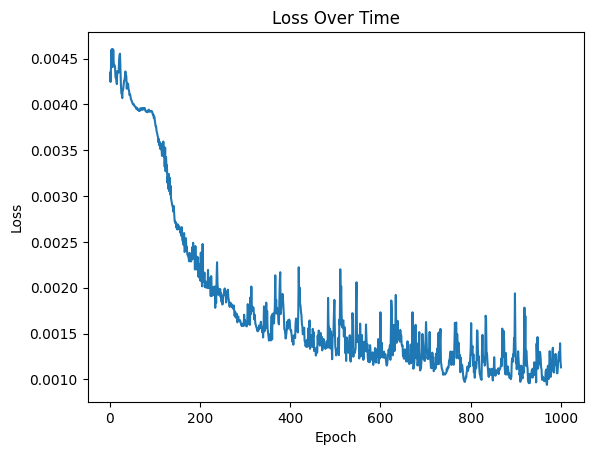

In [21]:
### TODO: make plot of reconstruction loss (y-axis) over training time (x-axis)
plt.plot(range(1, NUM_EPOCHS + 1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.show()

## Evaluation

In [10]:
# Load model
model_path = img_path + 'save_model.pt'
net.load_state_dict(torch.load(model_path))
net.eval()

FFN(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=3, bias=True)
  )
)

### Question 5: Reconstruct whole image (20 points)

For this part, reconstruct the image using your model's outputs, at each coordinate.
You can use our scaffolding code, or write your own.
For this part, we are just grading the image plot, where you should plot the original image side-by-side with the reconstruction, as shown in this example.

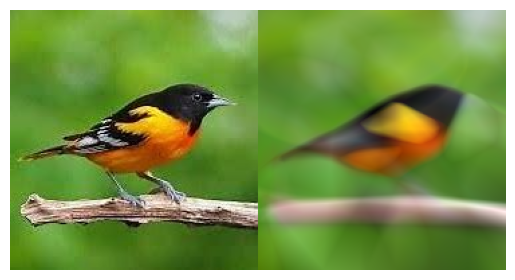

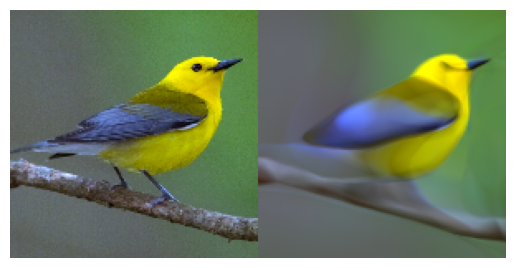

In [11]:
### TODO: ~12 lines of code to assemble gt_image, build pred_image
###       from model

img = read_image(img_path+'image.png')

gt_image = torch.zeros(img.shape)
pred_image = torch.zeros(img.shape)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
with torch.no_grad():
  for batch in dataloader:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]
    gt_image[:, y.item(), x.item()] = intensity*255

    x_ = x / dataset.w # normalizing x between 0 and 1
    y_ = y / dataset.h # normalizing y between 0 and 1

    coord = torch.stack((x_, y_), dim=-1)
    pred = net(coord.to(device))

    pred_image[:, y.item(), x.item()] = pred*255

pred_image = torch.clip(pred_image, 0, 255)

joint_image = torch.cat([gt_image.type(torch.uint8), pred_image.type(torch.uint8)], dim=2)
plt.imshow(joint_image.permute(1, 2, 0))
plt.axis('off')
plt.show()
plt.close()

### Question 6: Compute PSNR (10 points)

For this part, print the PSNR for your reconstruction vs. the original image. Feel free to use any libraries, or implement it from scratch.

In [12]:
### TODO: compute and print PSNR between reconstructed (predicted) and ground truth images
# import torch.nn.functional as F


if gt_image.shape != pred_image.shape:
    raise ValueError("Both images must have the same dimensions.")

mse = nn.functional.mse_loss(gt_image, pred_image)

max_value = torch.tensor(255, dtype=torch.uint8)

psnr = 20 * torch.log10(max_value) - 10 * torch.log10(mse)

print(f'PSNR: {psnr.item()} dB')

PSNR: 22.064388275146484 dB


### Question 7: Outpainting (10 points)

INR is a continuous image representation. What happens if your input coordinates don't correspond to real pixels? Try it out and show the result!

For this part, have your model predict 20 pixels in all directions that are outside the boundaries of the original image, and show the resulting image below. Also plot a box around the region corresponding to the original image, for clarity.

We show an example below.

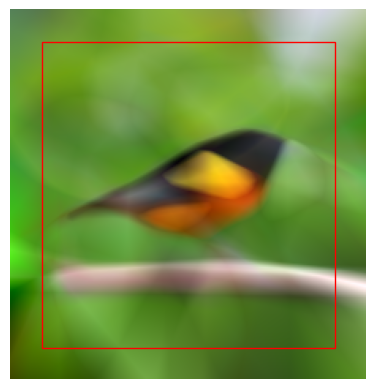

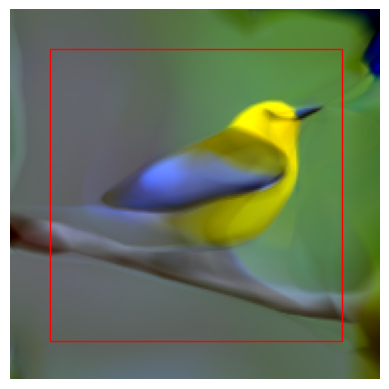

In [13]:
import matplotlib.patches as patches

### TODO: 6-10 lines of code to generate outpainted image
channels, height, width = pred_image.shape

# initialize the outpainted image
outpainted_image = torch.zeros(channels, height + 2*20, width + 2*20)

for x in range(outpainted_image.shape[2]):
  for y in range(outpainted_image.shape[1]):

    x_ = torch.tensor((x - 20) / dataset.w)
    y_ = torch.tensor((y - 20) / dataset.h)

    coord = torch.stack((x_, y_), dim=-1)

    pred = net(coord.to(device))

    outpainted_image[:, y, x] = 255*pred

outpainted_image = torch.clip(outpainted_image, 0, 255).type(torch.uint8)

fig, ax = plt.subplots()
ax.imshow(outpainted_image.permute(1, 2, 0))
rect = patches.Rectangle((20, 20), dataset.w, dataset.h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.show()
plt.close()

## Bonus

The main idea of the bonus is to do something to make your model better than the one we walk you through in the assignment. Be creative! You can receive a maximum of 20 points for this portion.

### Question 8: Improve the Reconstruction Quality of the System (20 points, optional)

For this question, you must do two things:

1. Make a non-trivial change from what we guided you through in the assignment.
2. Prove that the change improves reconstruction quality. Compare your new output/PSNR to the old output/PSNR (plot the images, print the PSNR).

If you can't think of your own idea, revisit some of the literature from Shishira's guest lectures. For example, instead of taking raw coordinate inputs, you could try using positional encodings.

In [ ]:
### TODO: bonus